In [1]:
%pip install pymongo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/Users/apple/Downloads/CSC_494/granger_analysis_on_tweet/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Original Tweets In-Community
- Here we will analyze the original tweets created by the users in the community

## Total Number of Original Tweets in Each Community

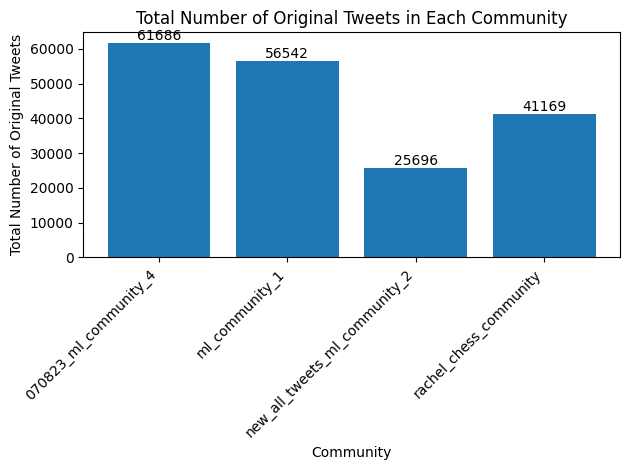

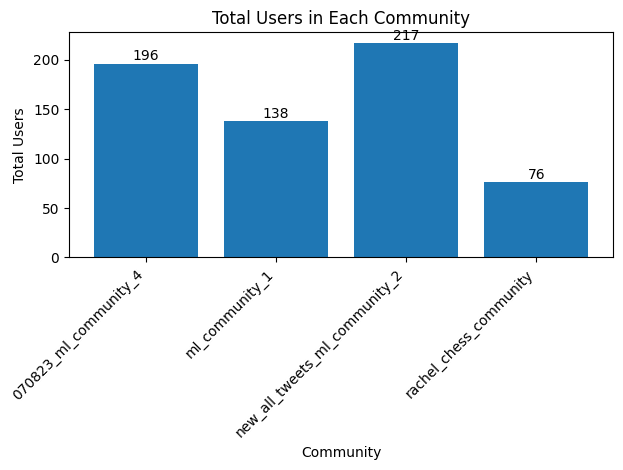

In [3]:
client = MongoClient('localhost', 27017)

databases = ['070823_ml_community_4', 'ml_community_1', 'new_all_tweets_ml_community_2', 'rachel_chess_community']
all_original_tweets = {}
all_user_info = {}
for db_name in databases:
    db = client[db_name]
    og_tweet_collection = db['original_tweets']
    og_tweet_df = pd.DataFrame(list(og_tweet_collection.find()))
    og_tweet_df['user_id'] = og_tweet_df['user_id'].astype(int)
    all_original_tweets[db_name] = og_tweet_df

    user_collection = db['user_info']
    user_df = pd.DataFrame(list(user_collection.find()))
    user_df['userid'] = user_df['userid'].astype(int)
    all_user_info[db_name] = user_df

# 1. create the plot for total OG tweets
total_counts = {db_name: df.shape[0] for db_name, df in all_original_tweets.items()}
db_names = list(total_counts.keys())
counts = list(total_counts.values())

plt.figure()
plt.bar(db_names, counts)
plt.xlabel('Community')
plt.ylabel('Total Number of Original Tweets')
plt.title('Total Number of Original Tweets in Each Community')

plt.xticks(rotation=45, ha='right')
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()

# 2. create the plot for total users
total_user = {db_name: df.shape[0] for db_name, df in all_user_info.items()}
db_names_2 = list(total_user.keys())
counts_2 = list(total_user.values())

plt.figure()
plt.bar(db_names_2, counts_2)
plt.xlabel('Community')
plt.ylabel('Total Users')
plt.title('Total Users in Each Community')

plt.xticks(rotation=45, ha='right')
for i, count in enumerate(counts_2):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()


## Original Tweets Distribution by User for Each Community

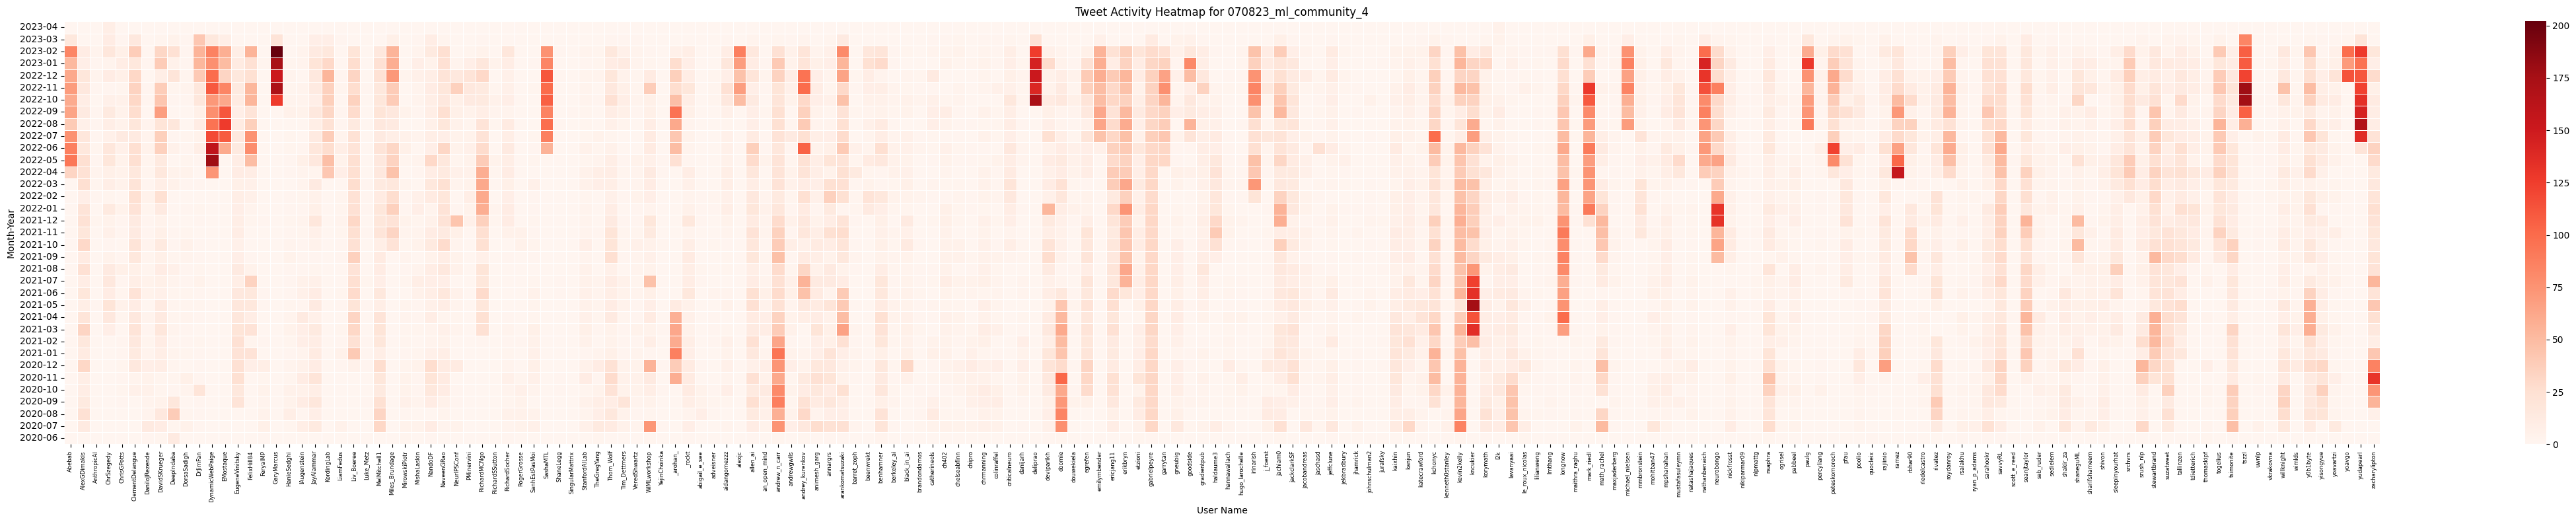

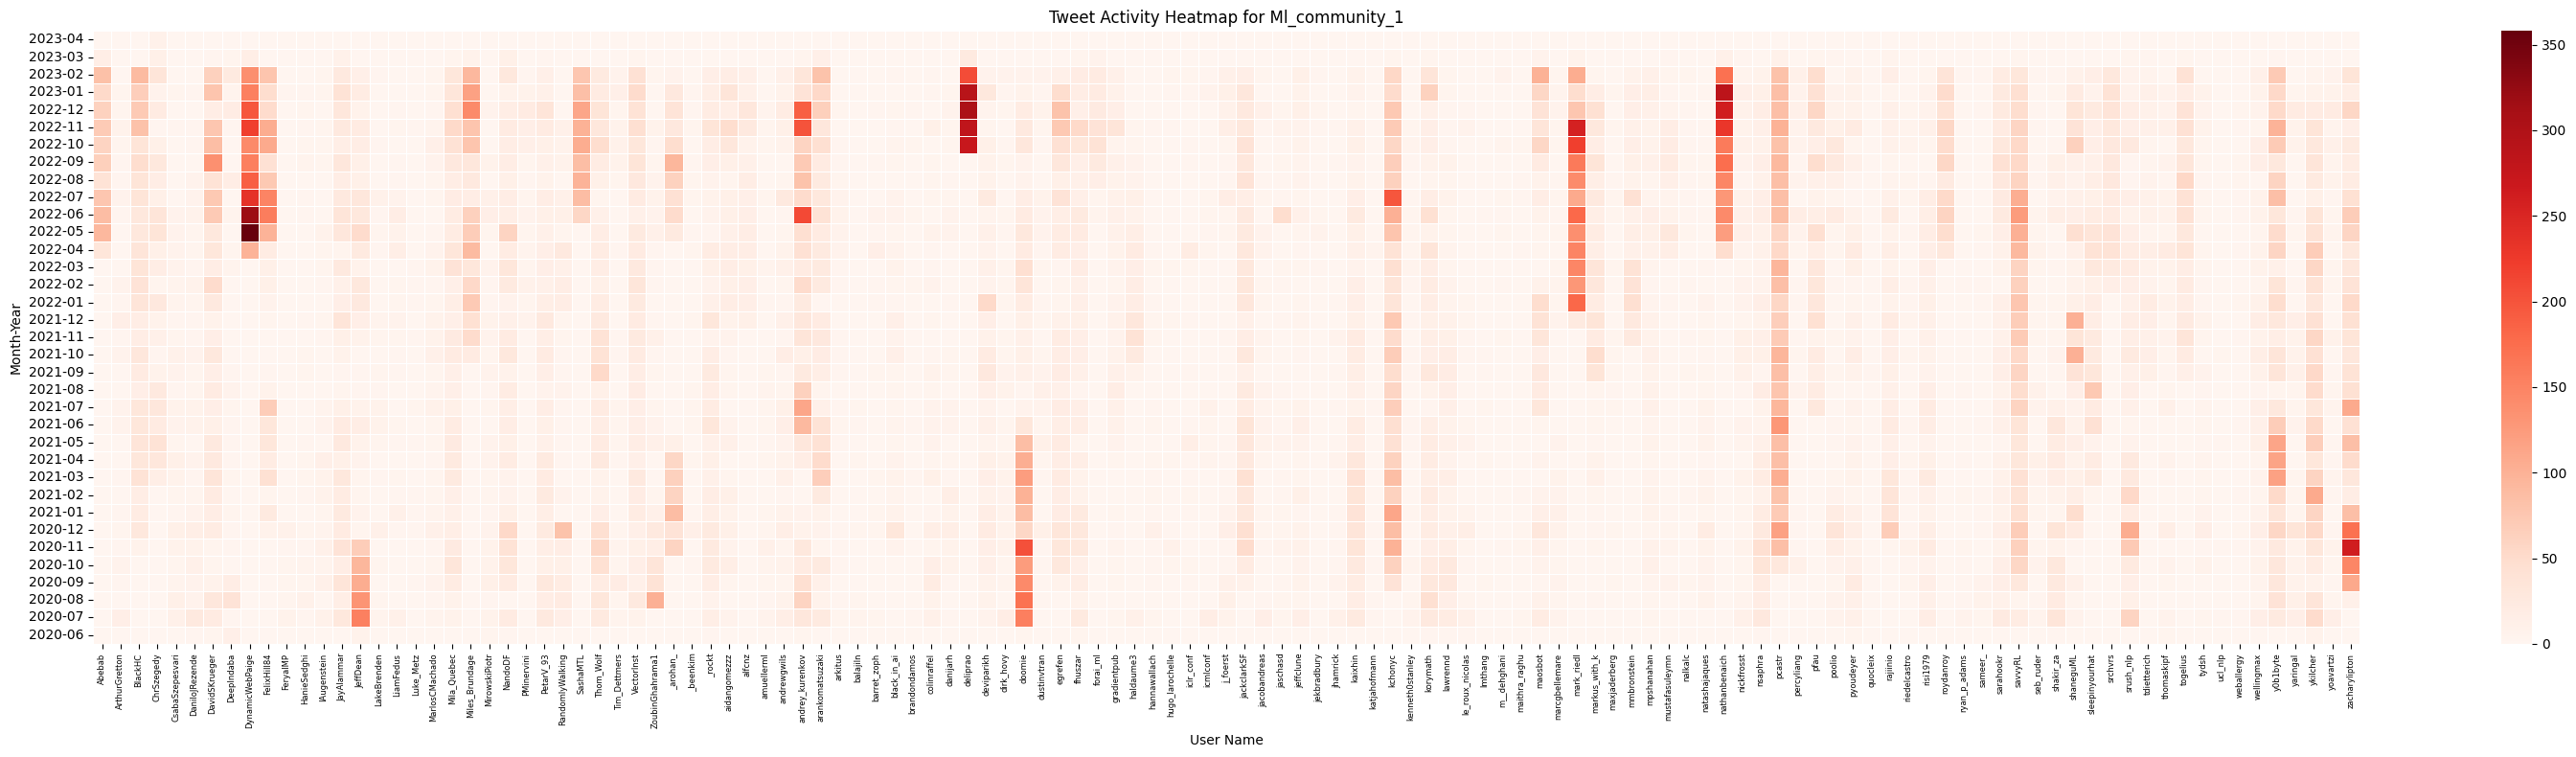

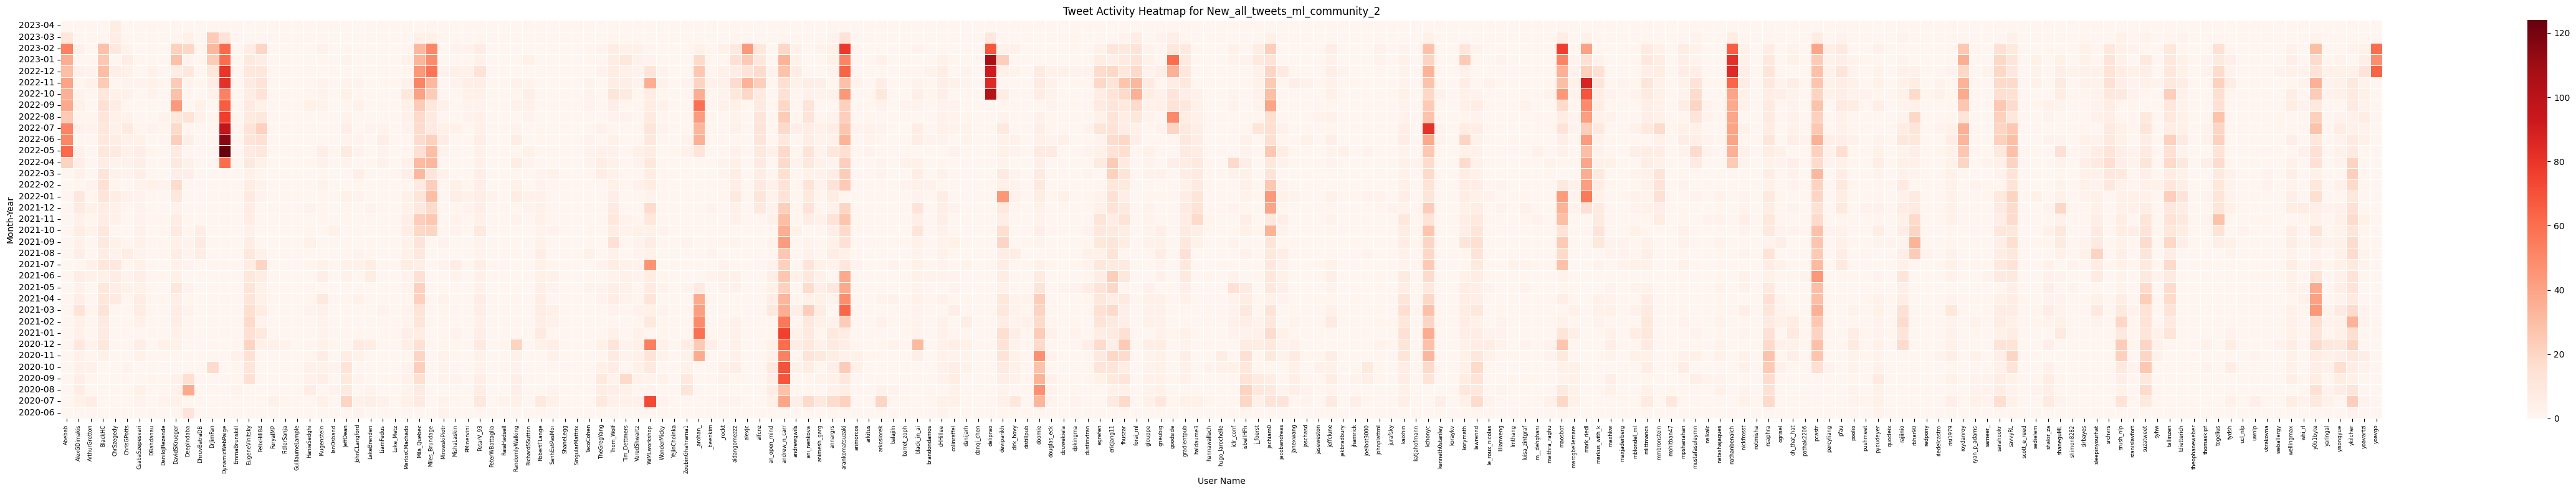

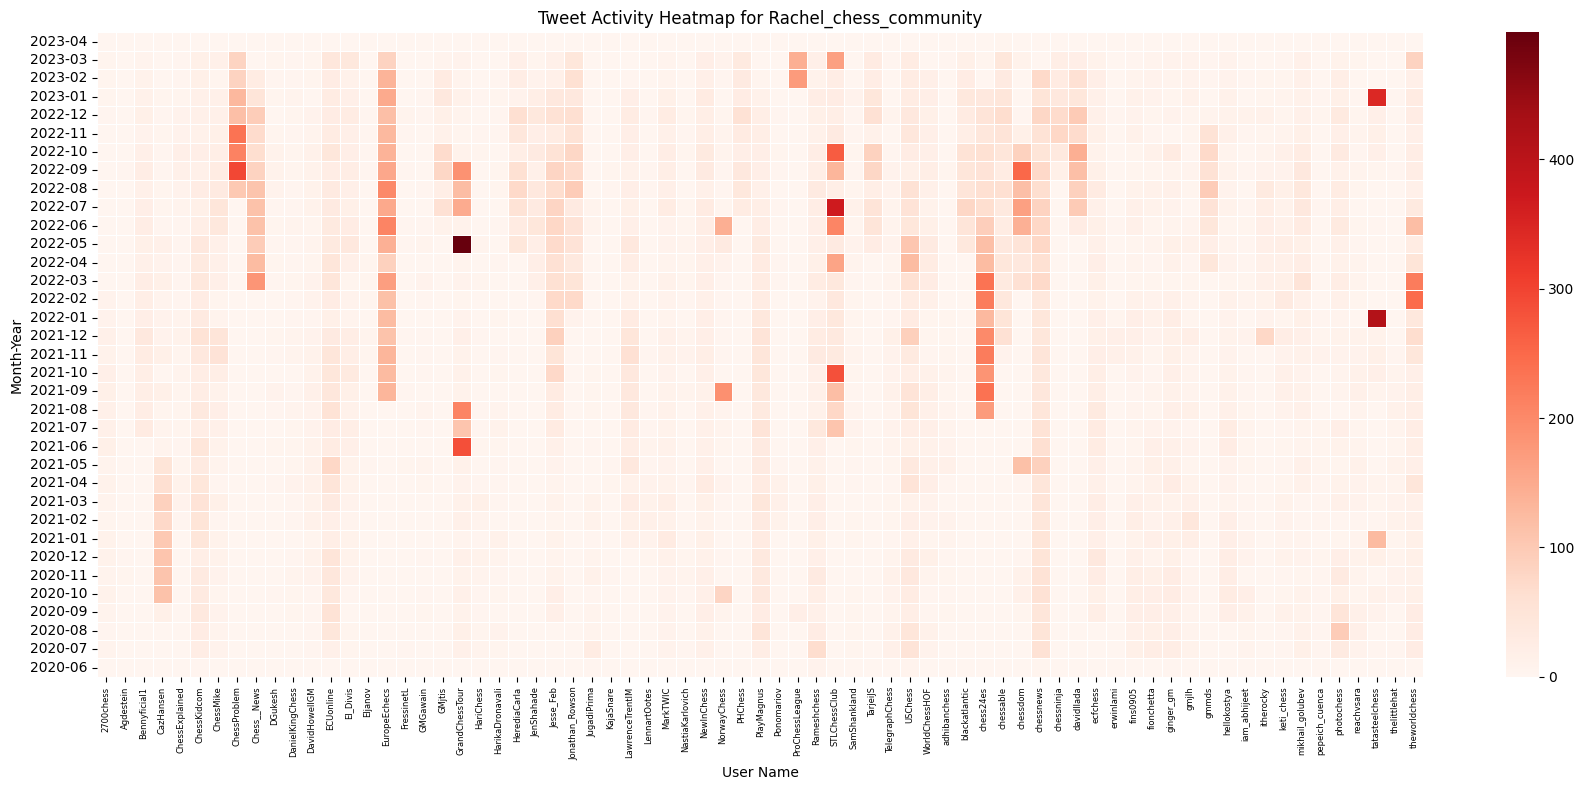

In [4]:
from collections import defaultdict


total_tweets = defaultdict(list) # to be used later for avg
top_users_by_community = {}
bottom_users_by_community = {}
users_not_tweeted_by_community = defaultdict(list)

for community, df in all_original_tweets.items():
    all_user_info[community].rename(columns={'userid': 'user_id'}, inplace=True)
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['month_year'] = df['created_at'].dt.to_period('M')

    df = pd.merge(df, all_user_info[community], on='user_id', how='left', suffixes=('', '_user_info'))

    # right join to be used later to find users who have not tweeted anything
    df_not_tweeted = pd.merge(df, all_user_info[community], on='user_id', how='right', suffixes=('', '_user_info'))
    users_not_tweeted = df_not_tweeted[df_not_tweeted['created_at'].isna()]
    usernames_not_tweeted = users_not_tweeted['username_user_info'].to_list()
    users_not_tweeted_by_community[community] = usernames_not_tweeted

    # count the tweet per user for each period
    tweet_count = df.groupby(['username', 'month_year']).size()

    # calculate total tweets in that community
    total_tweets[community].append(tweet_count.sum())
    total_tweets[community].append(all_user_info[community]['user_id'].nunique())

    # calculate the top users in that community
    tweet_count_per_user = tweet_count.groupby('username').sum()
    top_20_users = tweet_count_per_user.sort_values(ascending=False).head(20)
    top_users_by_community[community] = top_20_users

    # calculate the bottom users in that community
    bottom_20_users = tweet_count_per_user.sort_values(ascending=True).head(20)
    bottom_users_by_community[community] = bottom_20_users

    # convert series to dataframe for heatmap and transpose
    tweet_count_unstacked = tweet_count.unstack(fill_value=0).T
    tweet_count_unstacked.columns = tweet_count_unstacked.columns.astype(str)

    #create the plot
    plt.figure(figsize=(len(tweet_count_unstacked.columns) / 4, 8))
    plt.ticklabel_format(style='plain', axis='x')

    sns.heatmap(tweet_count_unstacked, cmap="Reds", linewidths=.5)
    
    plt.xlabel('User Name')
    plt.ylabel('Month-Year')
    plt.title(f'Tweet Activity Heatmap for {community.capitalize()}')

    plt.gca().invert_yaxis()
    plt.xticks(rotation=90, fontsize=6)
    plt.tight_layout()
    plt.show()

## Average Tweet by User in Each Community 

In [5]:
og_tweet_average = defaultdict(float)
for community, lst in total_tweets.items():
    average = lst[0] / lst[1]
    og_tweet_average[community] = average

average_df = pd.DataFrame.from_dict(og_tweet_average, orient='index', columns=['Average Tweets per User'])
print(average_df)

                               Average Tweets per User
070823_ml_community_4                       314.724490
ml_community_1                              409.724638
new_all_tweets_ml_community_2               118.414747
rachel_chess_community                      541.697368


## Top Tweeters and Bottom Tweeters in Each Community

- Here we are looking at users who have already tweeted something, exclusing those who have not tweeted anything

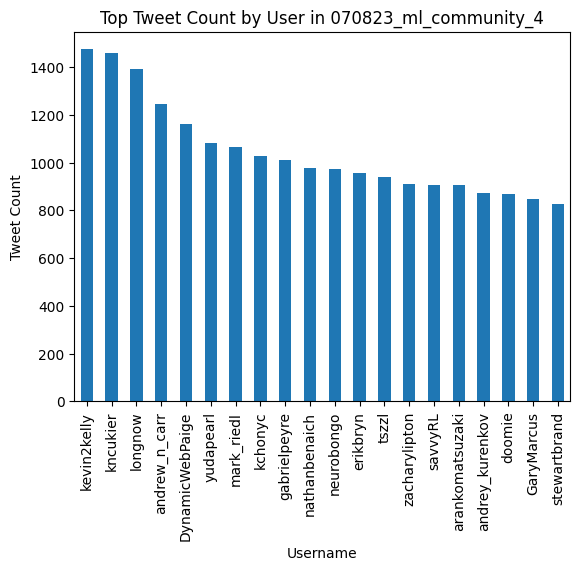

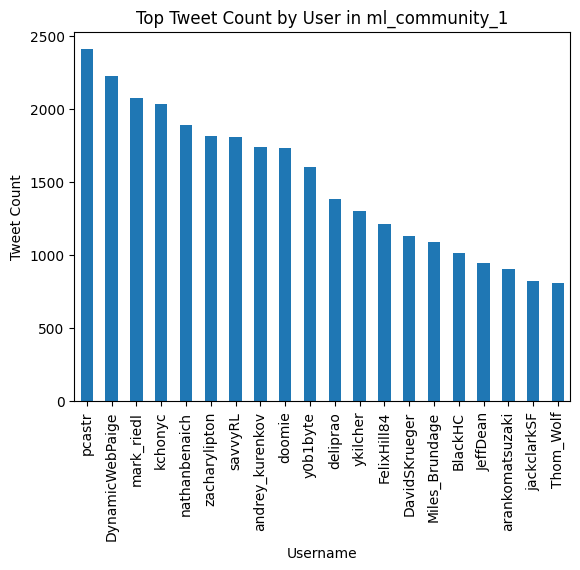

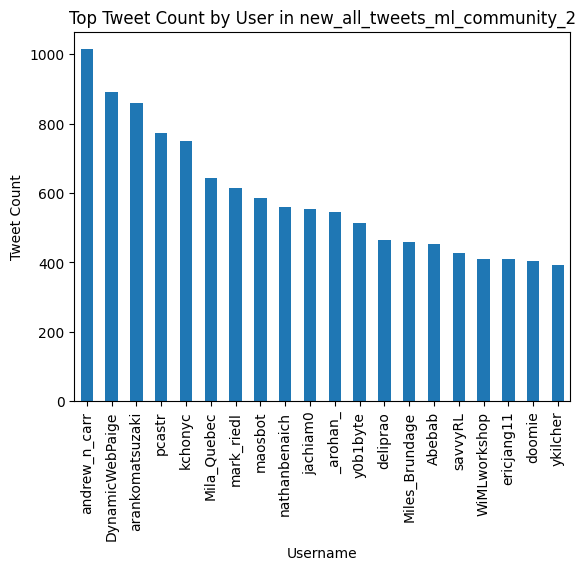

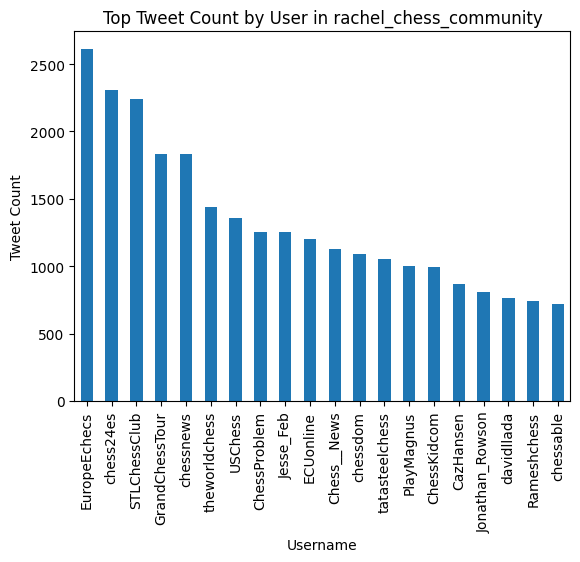

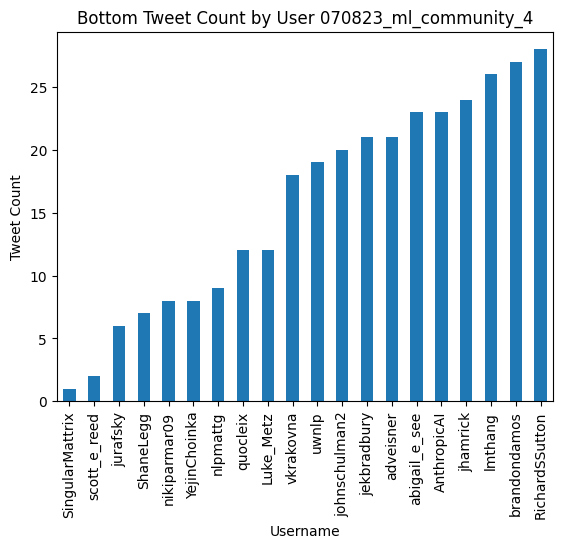

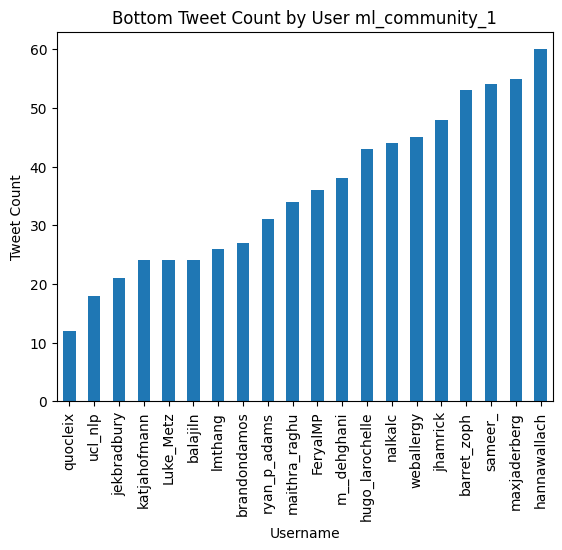

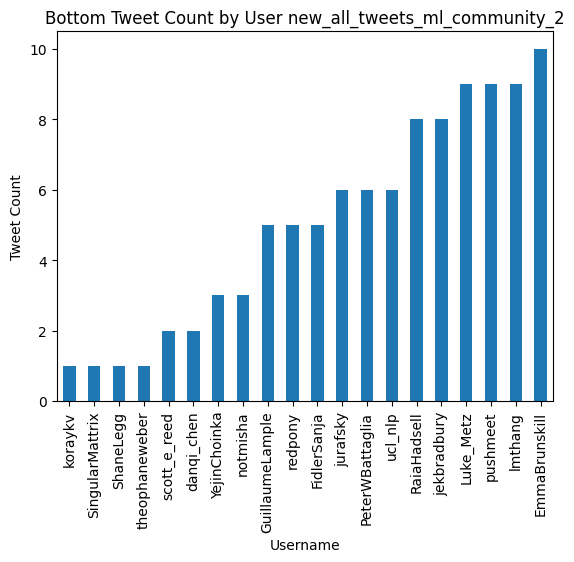

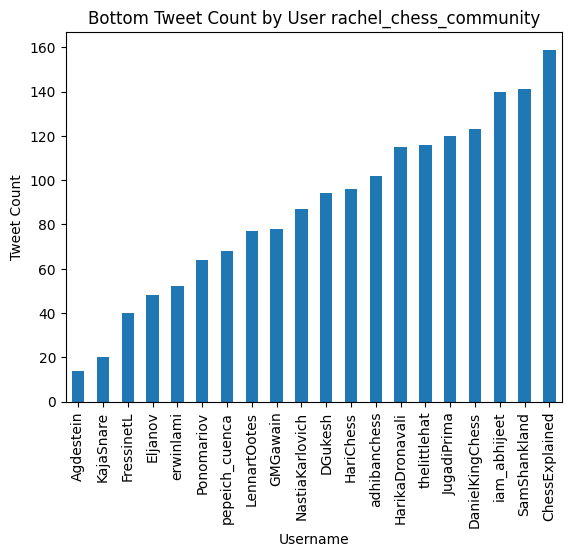

In [6]:
# convert the series to df for better visualization
for community, series in top_users_by_community.items():
    df = series.reset_index()
    df.columns = ['Username', 'Tweet Count']
    df.plot(kind='bar', x='Username', y='Tweet Count', legend=False)
    plt.xlabel('Username')
    plt.ylabel('Tweet Count')
    plt.title(f'Top Tweet Count by User in {community}')
    plt.show()

for community, series in bottom_users_by_community.items():
    df = series.reset_index()
    df.columns = ['Username', 'Tweet Count']
    df.plot(kind='bar', x='Username', y='Tweet Count', legend=False)
    plt.xlabel('Username')
    plt.ylabel('Tweet Count')
    plt.title(f'Bottom Tweet Count by User {community}')
    plt.show()


## Users Who Have Never Tweeted in Each Community

In [7]:
for community, series in users_not_tweeted_by_community.items():
    print(community)
    print("Total user count: " + str(len(series)))
    print(series)
    print('\n')

070823_ml_community_4
Total user count: 16
['mmitchell_ai', 'LukeZettlemoyer', 'CohereAI', '_jasonwei', 'mervenoyann', 'HochreiterSepp', 'zzznah', 'BlancheMinerva', 'woj_zaremba', 'Diyi_Yang', 'janleike', 'dileeplearning', 'mo_norouzi', 'polynoamial', 'AnimaAnandkumar', 'AdeptAILabs']


ml_community_1
Total user count: 15
['CohereAI', 'yeewhye', 'MLStreetTalk', 'alex_conneau', 'polynoamial', '_jasonwei', 'mmitchell_ai', 'AndrewLampinen', 'mo_norouzi', 'neuro_kim', 'gregd_nlp', 'neu_rips', 'zzznah', 'vdbergrianne', 'CShorten30']


new_all_tweets_ml_community_2
Total user count: 26
['_jasonwei', 'mo_norouzi', 'LukeZettlemoyer', 'yeewhye', 'vdbergrianne', 'ELLISforEurope', 'santoroAI', 'AndrewLampinen', 'polynoamial', 'svlevine', 'EthanJPerez', 'ibab_ml', 'CohereAI', 'ml_perception', 'iatitov', 'HochreiterSepp', 'dileeplearning', 'neu_rips', 'alex_conneau', 'AdeptAILabs', 'woj_zaremba', 'zzznah', 'gregd_nlp', 'neuro_kim', 'janleike', 'BlancheMinerva']


rachel_chess_community
Total user c

# Retweets by In-Community
- Here we will be analyzing the retweets between the users in the community
- *user_id* is the id of the user who retweeted. Here both *user_id* and *retweet_user_id* are both in community

## Total Retweets In-Community

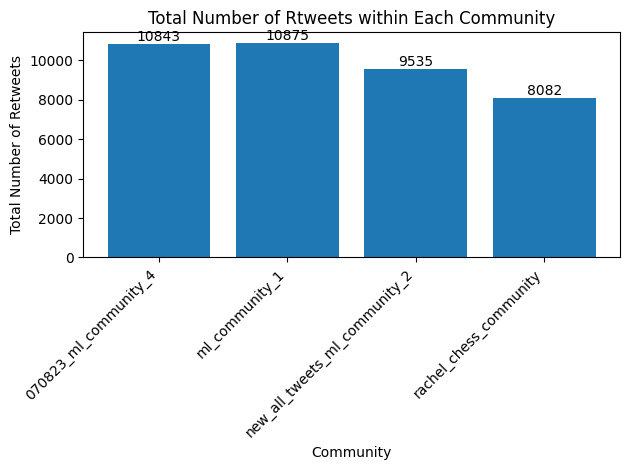

In [8]:
all_retweets_in_community = {}
for db_name in databases:
    db = client[db_name]
    retweet_collection = db['retweets_of_in_community']
    retweet_df = pd.DataFrame(list(retweet_collection.find()))
    retweet_df['user_id'] = retweet_df['user_id'].astype(int)
    retweet_df['retweet_user_id'] = retweet_df['user_id'].astype(int)
    all_retweets_in_community[db_name] = retweet_df


# 1. create the plot for total OG tweets
total_counts = {db_name: df.shape[0] for db_name, df in all_retweets_in_community.items()}
db_names = list(total_counts.keys())
counts = list(total_counts.values())

plt.figure()
plt.bar(db_names, counts)
plt.xlabel('Community')
plt.ylabel('Total Number of Retweets')
plt.title('Total Number of Rtweets within Each Community')

plt.xticks(rotation=45, ha='right')
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()

## In Community Retweet Distribution by User for Each Community

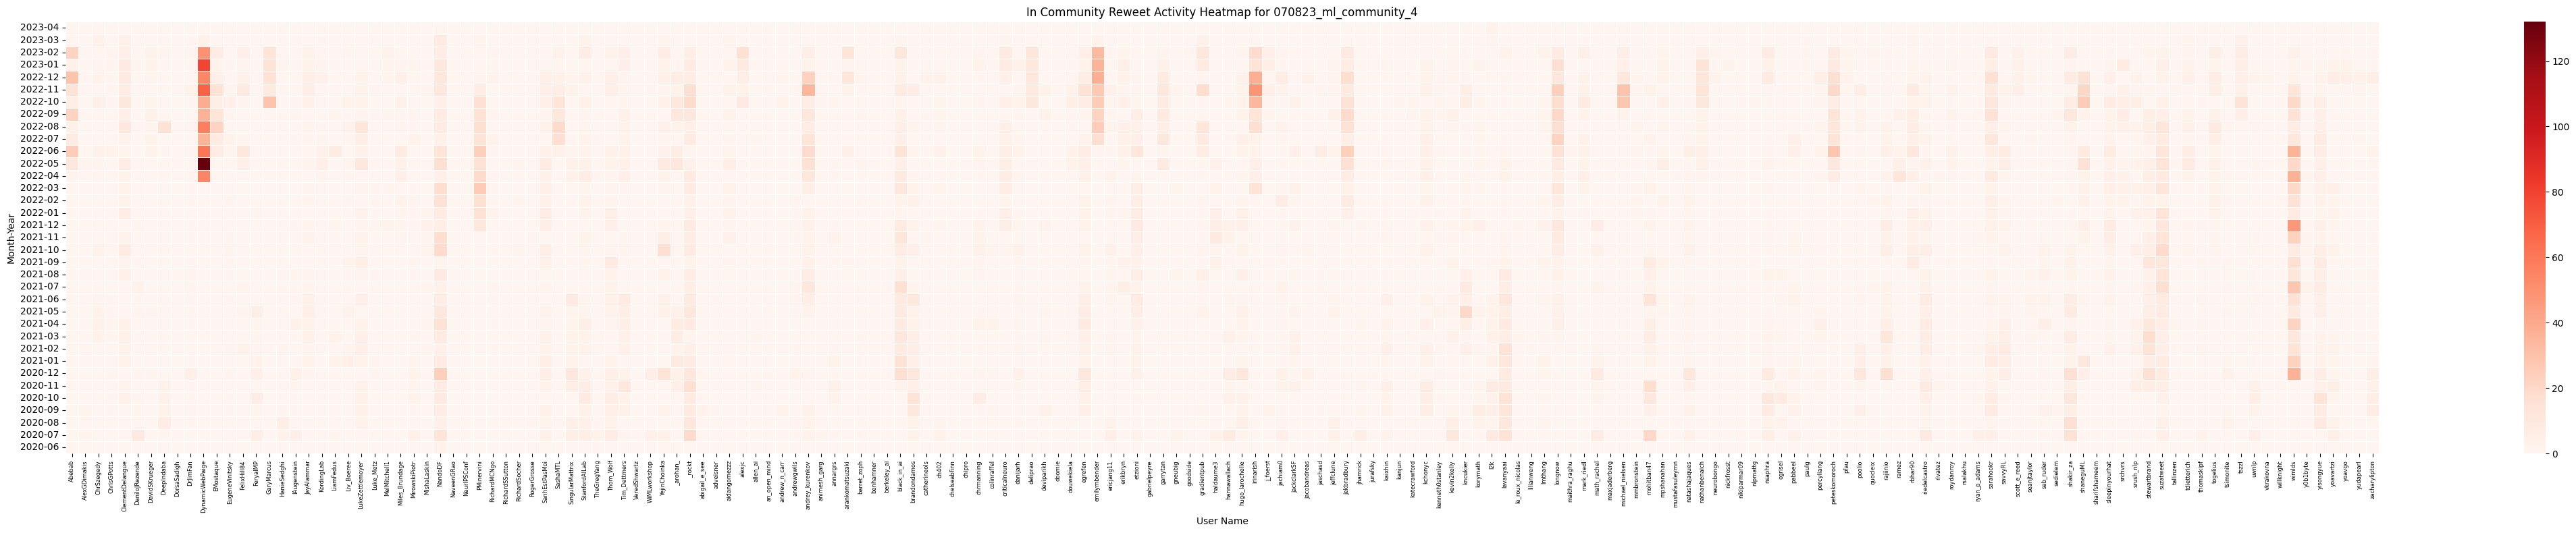

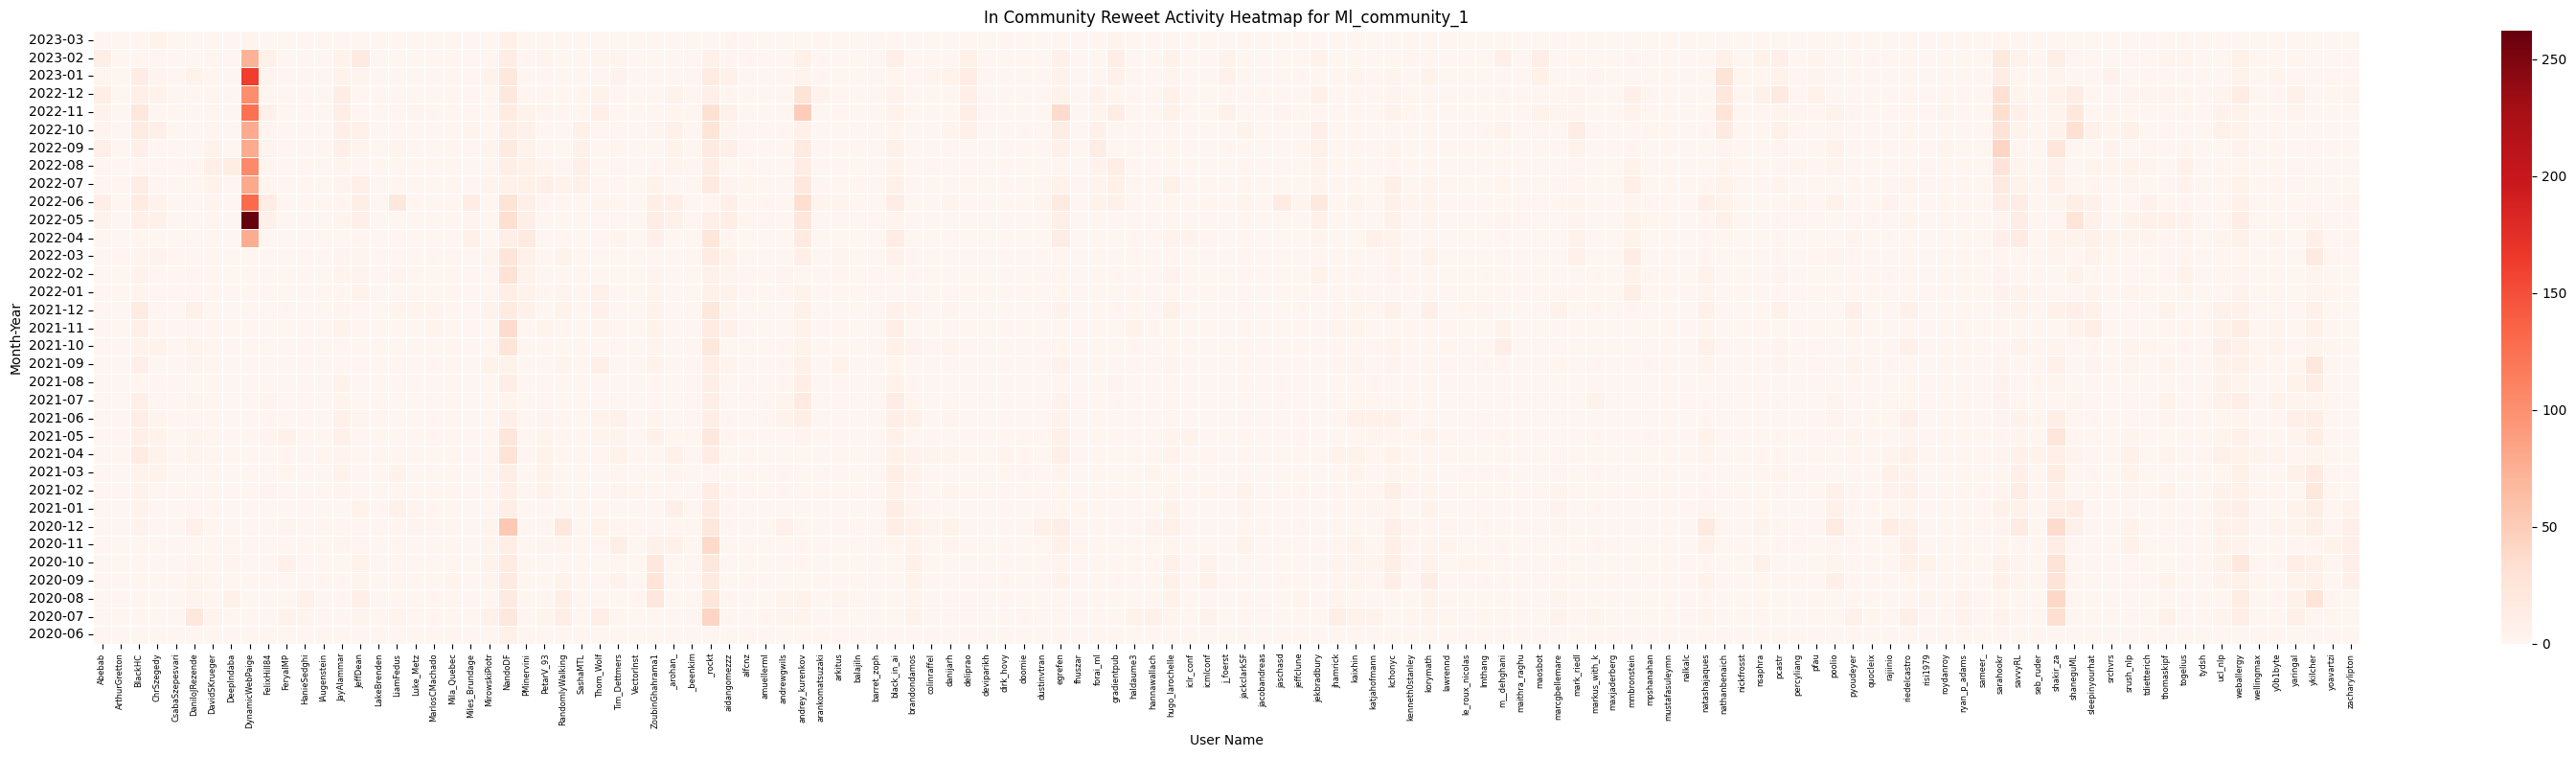

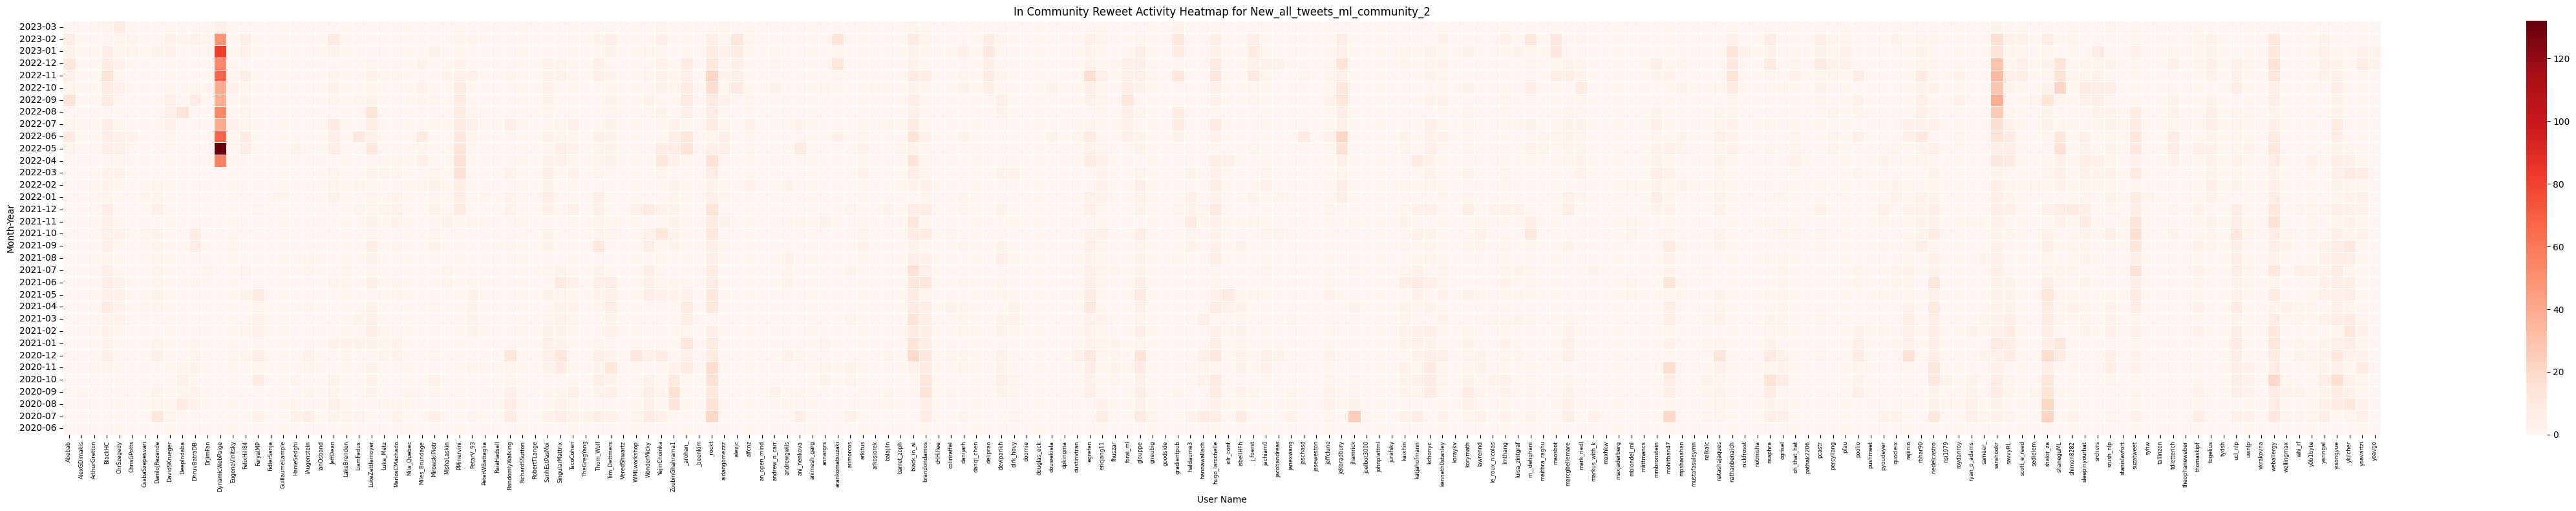

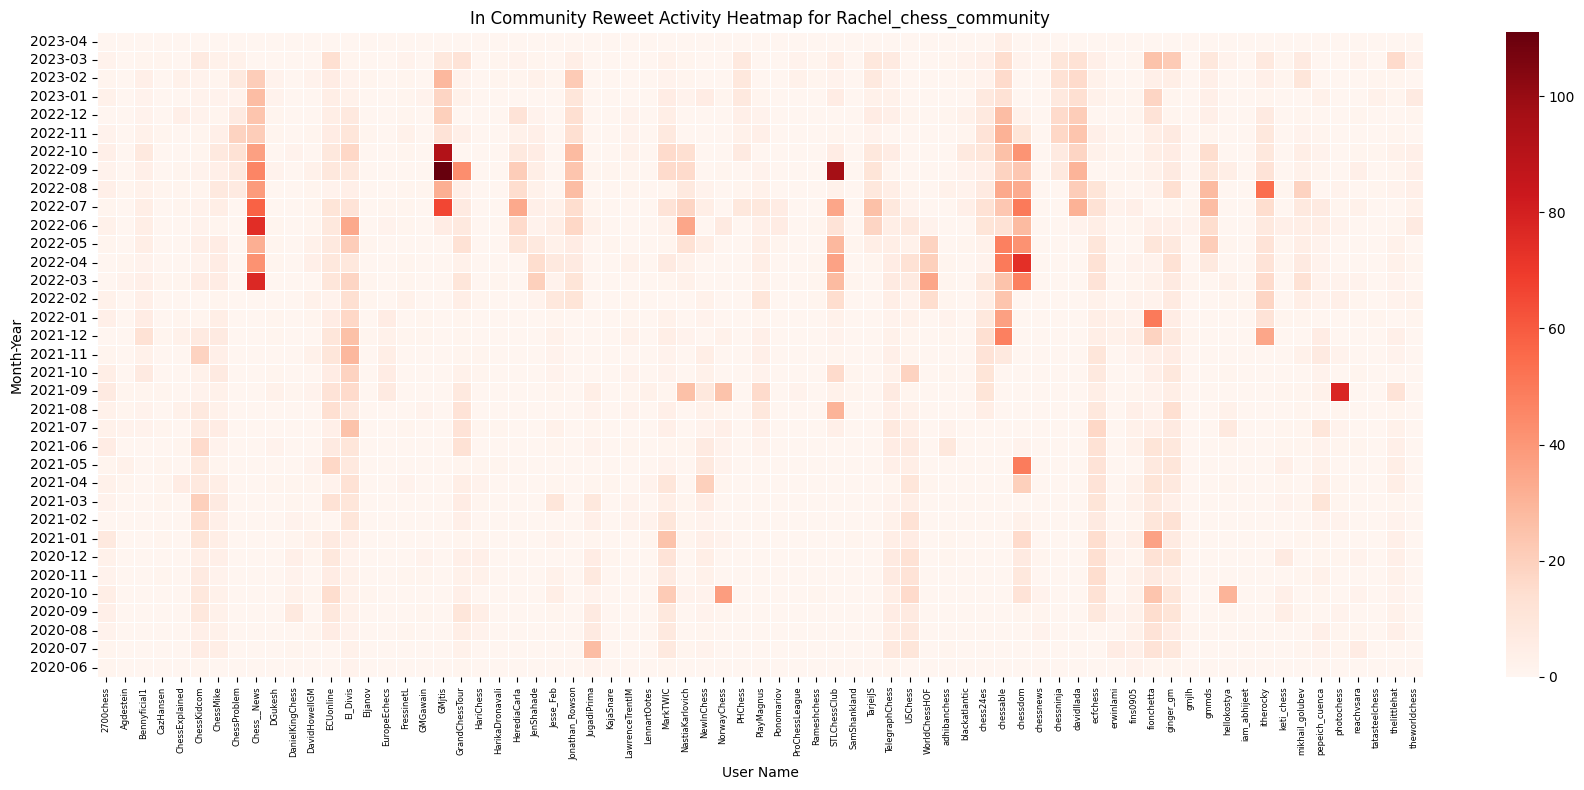

In [9]:
total_retweets = defaultdict(list) # to be used later for avg
top_users_by_community_retweet = {}
bottom_users_by_community_retweet = {}
users_no_in_community_retweet = defaultdict(list)

#TODO: add anaylsis for looking at which member got their tweet retweeted the most

for community, df in all_retweets_in_community.items():
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['month_year'] = df['created_at'].dt.to_period('M')

    df = pd.merge(df, all_user_info[community], on='user_id', how='left', suffixes=('', '_user_info'))

    # right join to be used later to find users who have not retweeted anything in community
    df_not_tweeted = pd.merge(df, all_user_info[community], on='user_id', how='right', suffixes=('', '_user_info'))
    users_not_tweeted = df_not_tweeted[df_not_tweeted['created_at'].isna()]
    usernames_not_tweeted = users_not_tweeted['username_user_info'].to_list()
    users_no_in_community_retweet[community] = usernames_not_tweeted

    # count the tweet per user for each period
    tweet_count = df.groupby(['username', 'month_year']).size()

    # calculate total tweets in that community
    total_retweets[community].append(tweet_count.sum())
    total_retweets[community].append(all_user_info[community]['user_id'].nunique())

    # calculate the top users in that community
    tweet_count_per_user = tweet_count.groupby('username').sum()
    top_20_users = tweet_count_per_user.sort_values(ascending=False).head(20)
    top_users_by_community_retweet[community] = top_20_users

    # calculate the bottom users in that community
    bottom_20_users = tweet_count_per_user.sort_values(ascending=True).head(20)
    bottom_users_by_community_retweet[community] = bottom_20_users

    # convert series to dataframe for heatmap and transpose
    tweet_count_unstacked = tweet_count.unstack(fill_value=0).T
    tweet_count_unstacked.columns = tweet_count_unstacked.columns.astype(str)

    #create the plot
    plt.figure(figsize=(len(tweet_count_unstacked.columns) / 4, 8))
    plt.ticklabel_format(style='plain', axis='x')

    sns.heatmap(tweet_count_unstacked, cmap="Reds", linewidths=.5)
    
    plt.xlabel('User Name')
    plt.ylabel('Month-Year')
    plt.title(f'In Community Reweet Activity Heatmap for {community.capitalize()}')

    plt.gca().invert_yaxis()
    plt.xticks(rotation=90, fontsize=6)
    plt.tight_layout()
    plt.show()


## Users Whose Tweet was Retweeted the Most

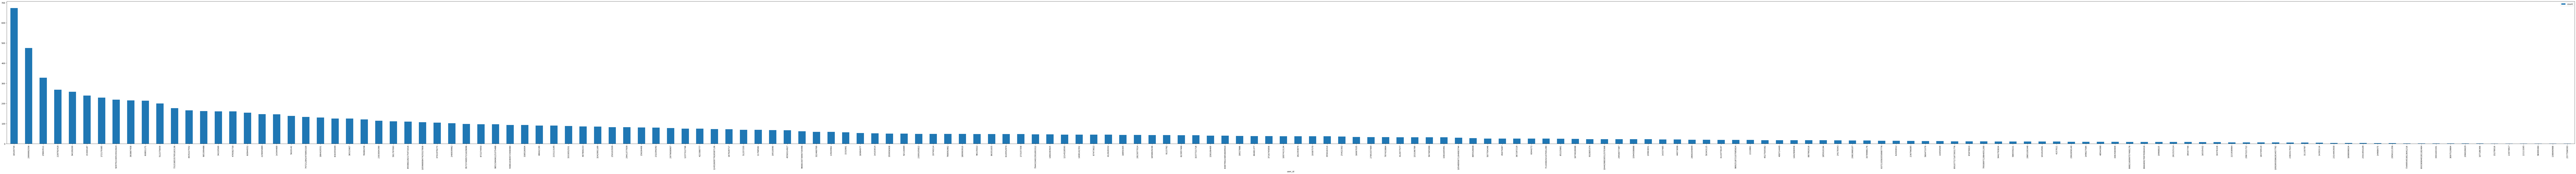

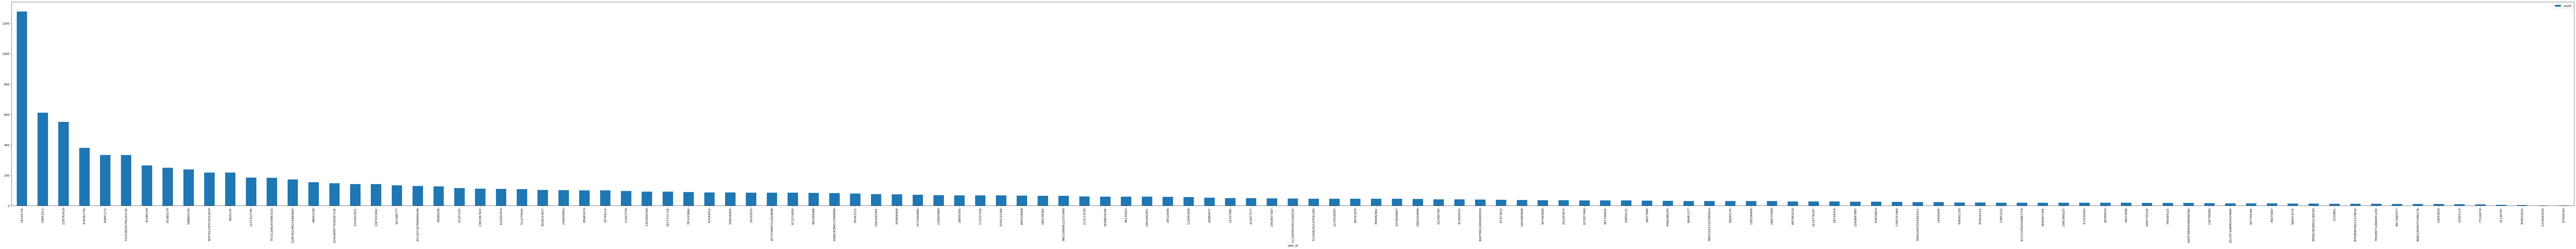

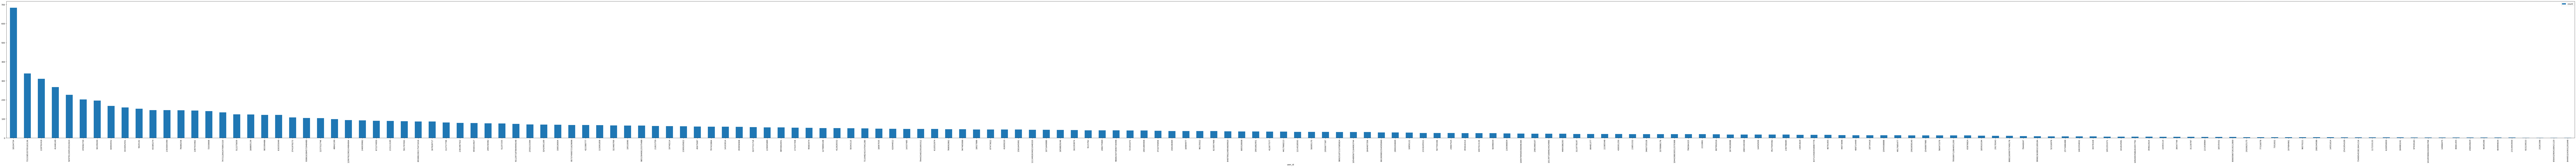

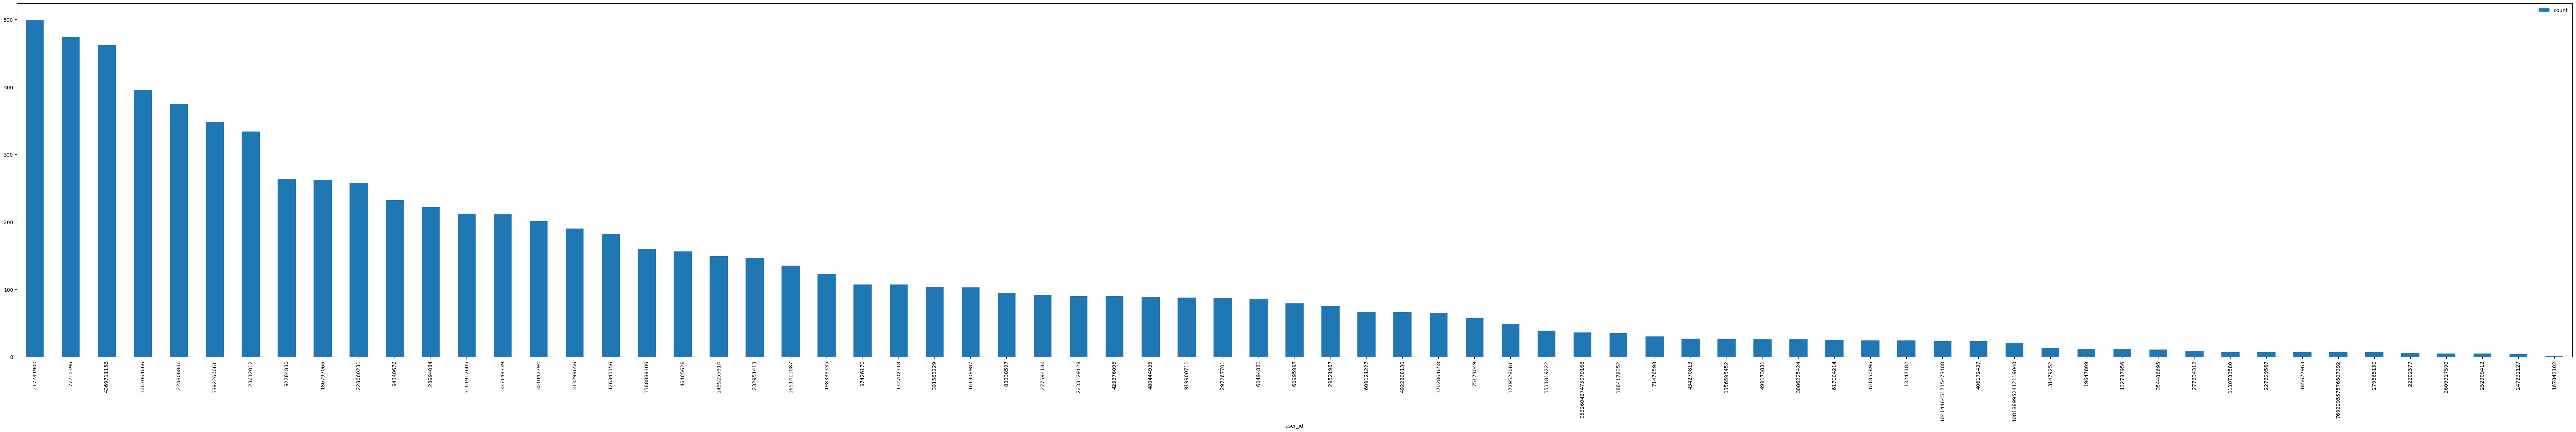

In [32]:
for community, retweet in all_retweets_in_community.items():
    retweet_counts = retweet.groupby('retweet_user_id').size().reset_index(name='count')
    retweet_counts_df = pd.DataFrame({
        "user_id": retweet_counts['retweet_user_id'],
        "count": retweet_counts['count']
    })
    retweet_counts_df = retweet_counts_df.sort_values(by='count', ascending=False)
    plt.figure(figsize=(len(retweet_counts_df), 12))
    retweet_counts_df.plot(kind='bar', x='user_id', y='count', ax=plt.gca())
    plt.tight_layout()
    plt.show()

## Average Retweets In-Community

In [11]:
retweet_average = defaultdict(float)
for community, lst in total_retweets.items():
    average = lst[0] / lst[1]
    retweet_average[community] = average

average_df = pd.DataFrame.from_dict(retweet_average, orient='index', columns=['Average Retweets per User'])
print(average_df)

                               Average Retweets per User
070823_ml_community_4                          55.321429
ml_community_1                                 78.804348
new_all_tweets_ml_community_2                  43.940092
rachel_chess_community                        106.342105


## Top and Bottom Retweeters In-Community
- Here we are only looking at those who have retweeted something within the community

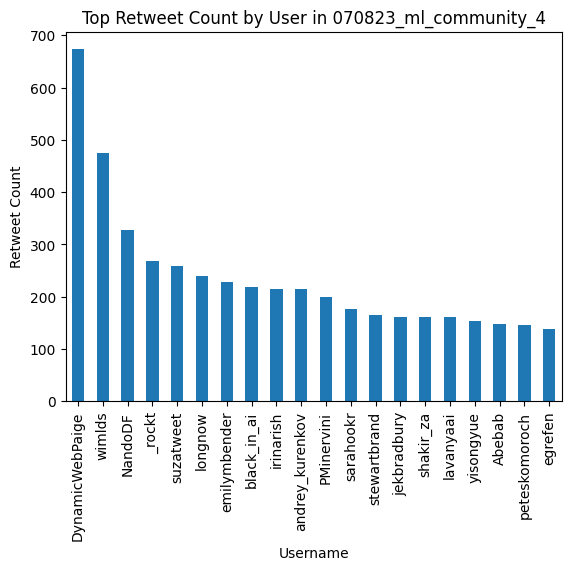

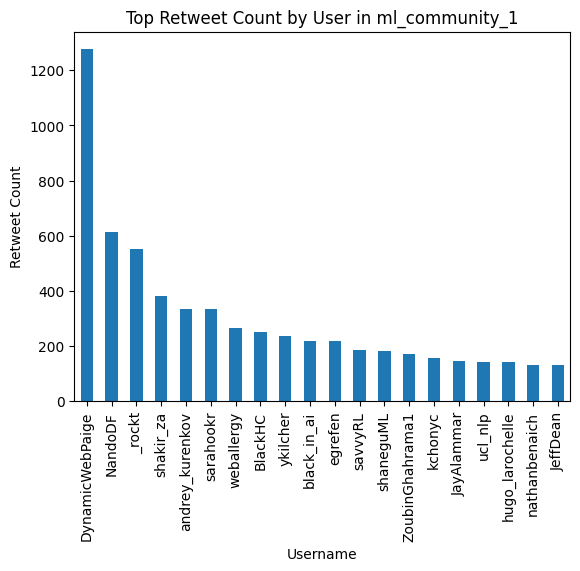

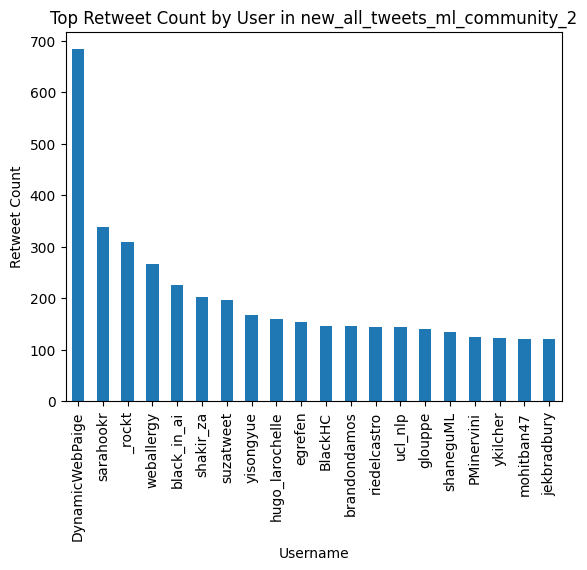

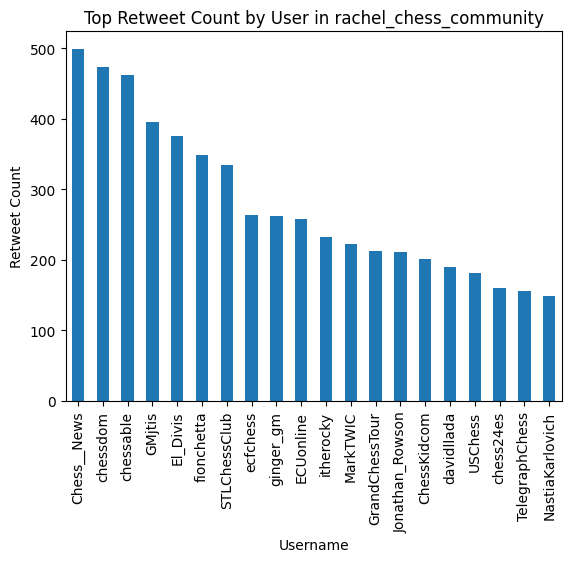

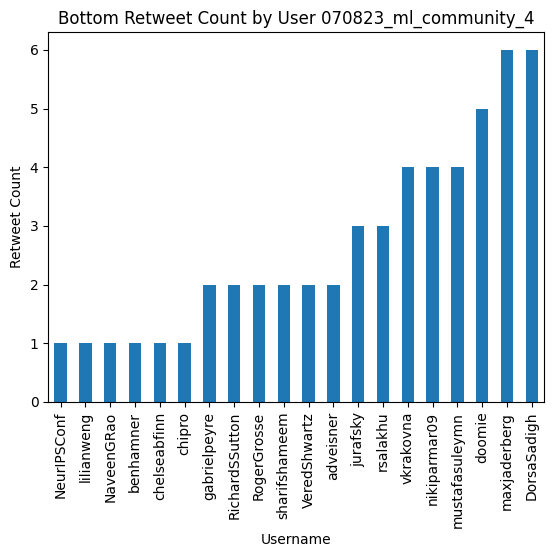

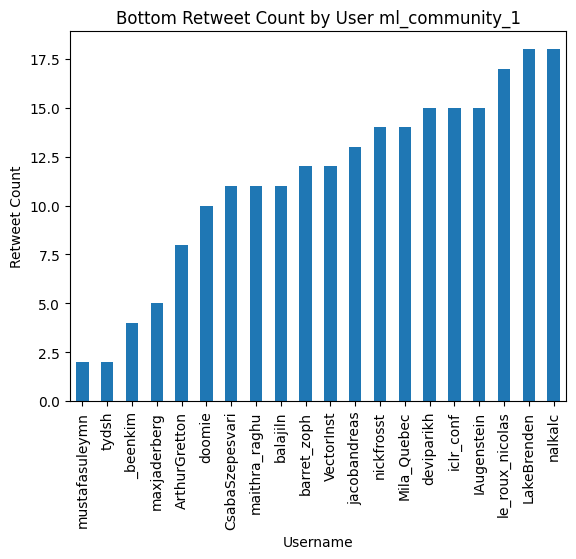

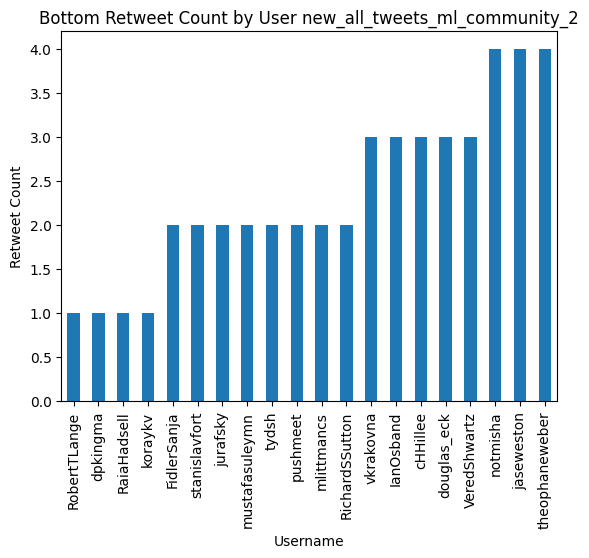

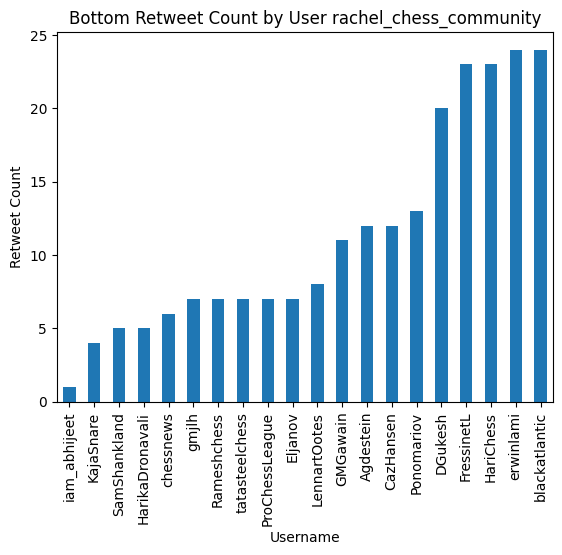

In [12]:
# convert the series to df for better visualization
for community, series in top_users_by_community_retweet.items():
    df = series.reset_index()
    df.columns = ['Username', 'Retweet Count']
    df.plot(kind='bar', x='Username', y='Retweet Count', legend=False)
    plt.xlabel('Username')
    plt.ylabel('Retweet Count')
    plt.title(f'Top Retweet Count by User in {community}')
    plt.show()

for community, series in bottom_users_by_community_retweet.items():
    df = series.reset_index()
    df.columns = ['Username', 'Retweet Count']
    df.plot(kind='bar', x='Username', y='Retweet Count', legend=False)
    plt.xlabel('Username')
    plt.ylabel('Retweet Count')
    plt.title(f'Bottom Retweet Count by User {community}')
    plt.show()

## Users Who Have Never Retweeted Anything In-Community

In [13]:
for community, series in users_no_in_community_retweet.items():
    print(community)
    print("Total user count: " + str(len(series)))
    print(series)
    print('\n')

070823_ml_community_4
Total user count: 20
['mmitchell_ai', 'AnthropicAI', 'CohereAI', '_jasonwei', 'mervenoyann', 'HochreiterSepp', 'zzznah', 'BlancheMinerva', 'woj_zaremba', 'Diyi_Yang', 'janleike', 'dileeplearning', 'ShaneLegg', 'beenwrekt', 'mo_norouzi', 'polynoamial', 'AnimaAnandkumar', 'AdeptAILabs', 'johnschulman2', 'shivon']


ml_community_1
Total user count: 15
['CohereAI', 'yeewhye', 'MLStreetTalk', 'alex_conneau', 'polynoamial', '_jasonwei', 'mmitchell_ai', 'AndrewLampinen', 'mo_norouzi', 'neuro_kim', 'gregd_nlp', 'neu_rips', 'zzznah', 'vdbergrianne', 'CShorten30']


new_all_tweets_ml_community_2
Total user count: 33
['_jasonwei', 'mo_norouzi', 'yeewhye', 'vdbergrianne', 'ELLISforEurope', 'santoroAI', 'AndrewLampinen', 'sirbayes', 'polynoamial', 'svlevine', 'EthanJPerez', 'ibab_ml', 'CohereAI', 'ml_perception', 'iatitov', 'HochreiterSepp', 'dileeplearning', 'JohnCLangford', 'lilianweng', 'neu_rips', 'distillpub', 'alex_conneau', 'AdeptAILabs', 'woj_zaremba', 'ShaneLegg', 'zz

# Retweets of Out-Community
- Retweets of out-community: tweets that are posted by out of community users and retweeted by in community users
- For rachel_chess_community it is named differently: *retweets_of_in_community_by_out_community*
- Here *retweet_user_id* is the user in the community, whereas *user_id* is the person who is out of the community

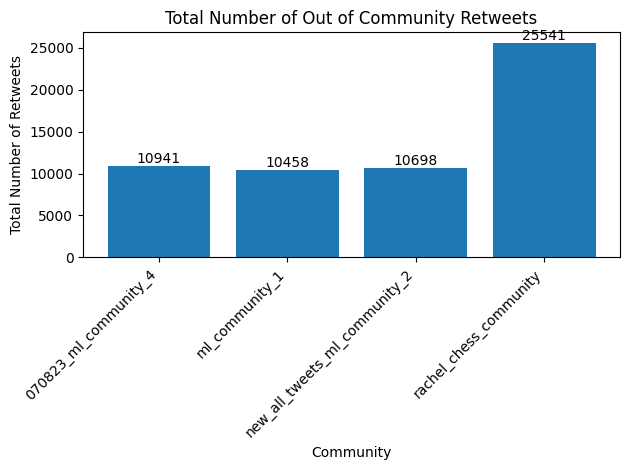

In [36]:
all_retweets_out_community = {}
for db_name in databases:
    db = client[db_name]

    if db_name != 'rachel_chess_community':
        retweet_collection = db['retweets_of_out_community']
    else:
        retweet_collection = db['retweets_of_in_community_by_out_community']

    retweet_df = pd.DataFrame(list(retweet_collection.find()))
    retweet_df['user_id'] = retweet_df['user_id'].astype(int)
    retweet_df['retweet_user_id'] = retweet_df['retweet_user_id'].astype(int)
    all_retweets_out_community[db_name] = retweet_df


# 1. create the plot for total tweets
total_counts = {db_name: df.shape[0] for db_name, df in all_retweets_out_community.items()}
db_names = list(total_counts.keys())
counts = list(total_counts.values())

plt.figure()
plt.bar(db_names, counts)
plt.xlabel('Community')
plt.ylabel('Total Number of Retweets')
plt.title('Total Number of Out of Community Retweets')

plt.xticks(rotation=45, ha='right')
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()

## Out Community Retweet Disctribution by User for Each Community
- Here we are looking at which user retweeted the most

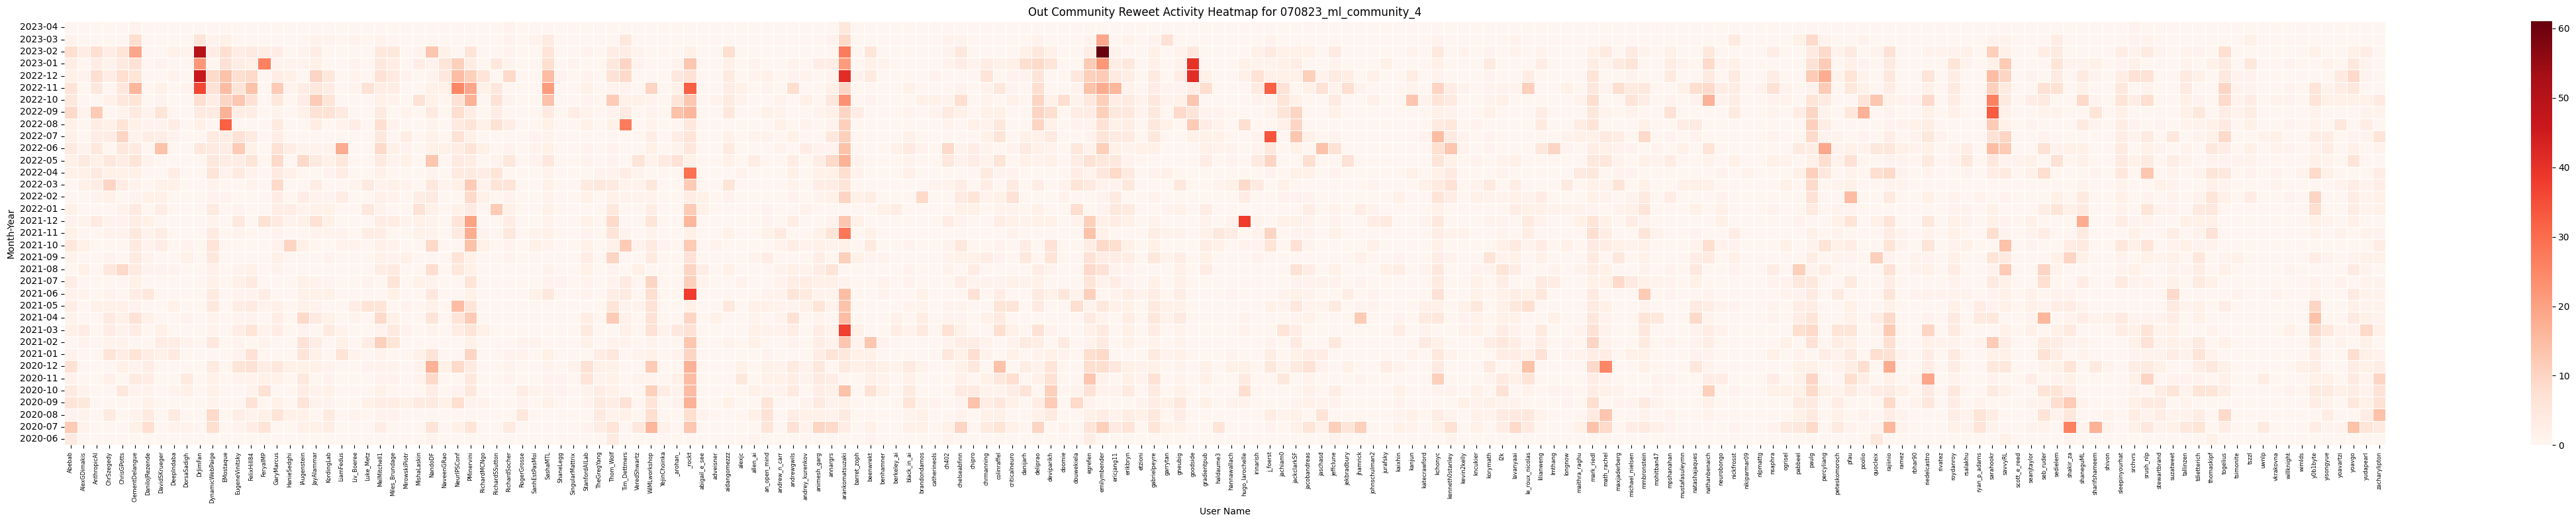

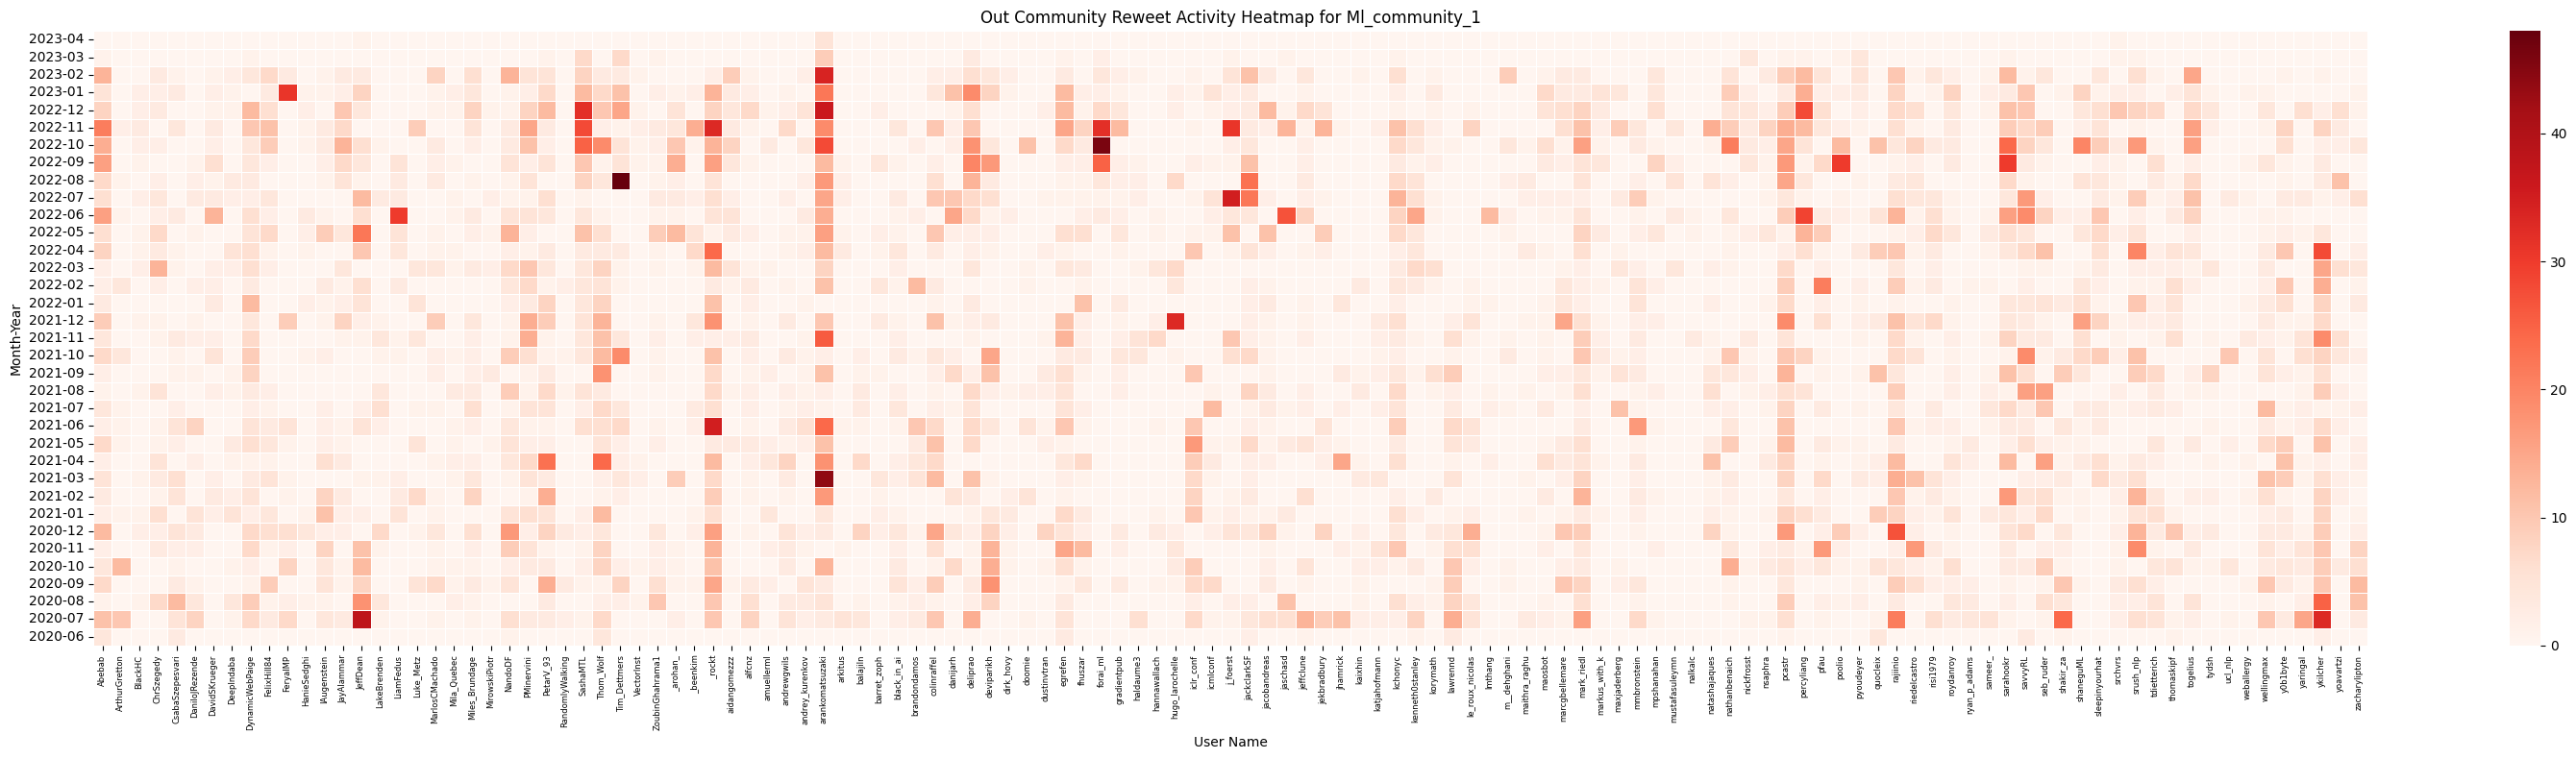

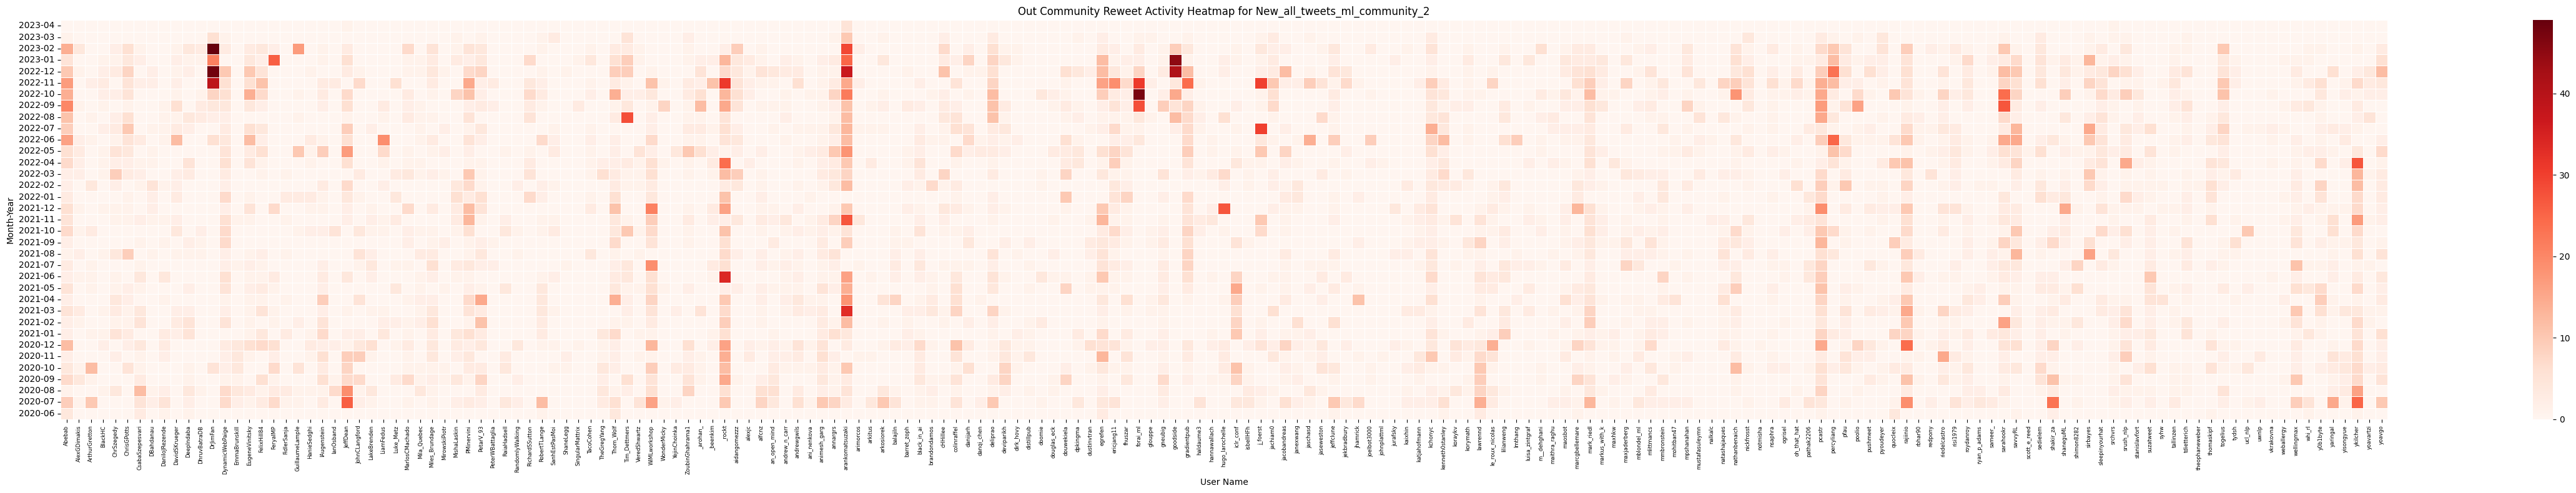

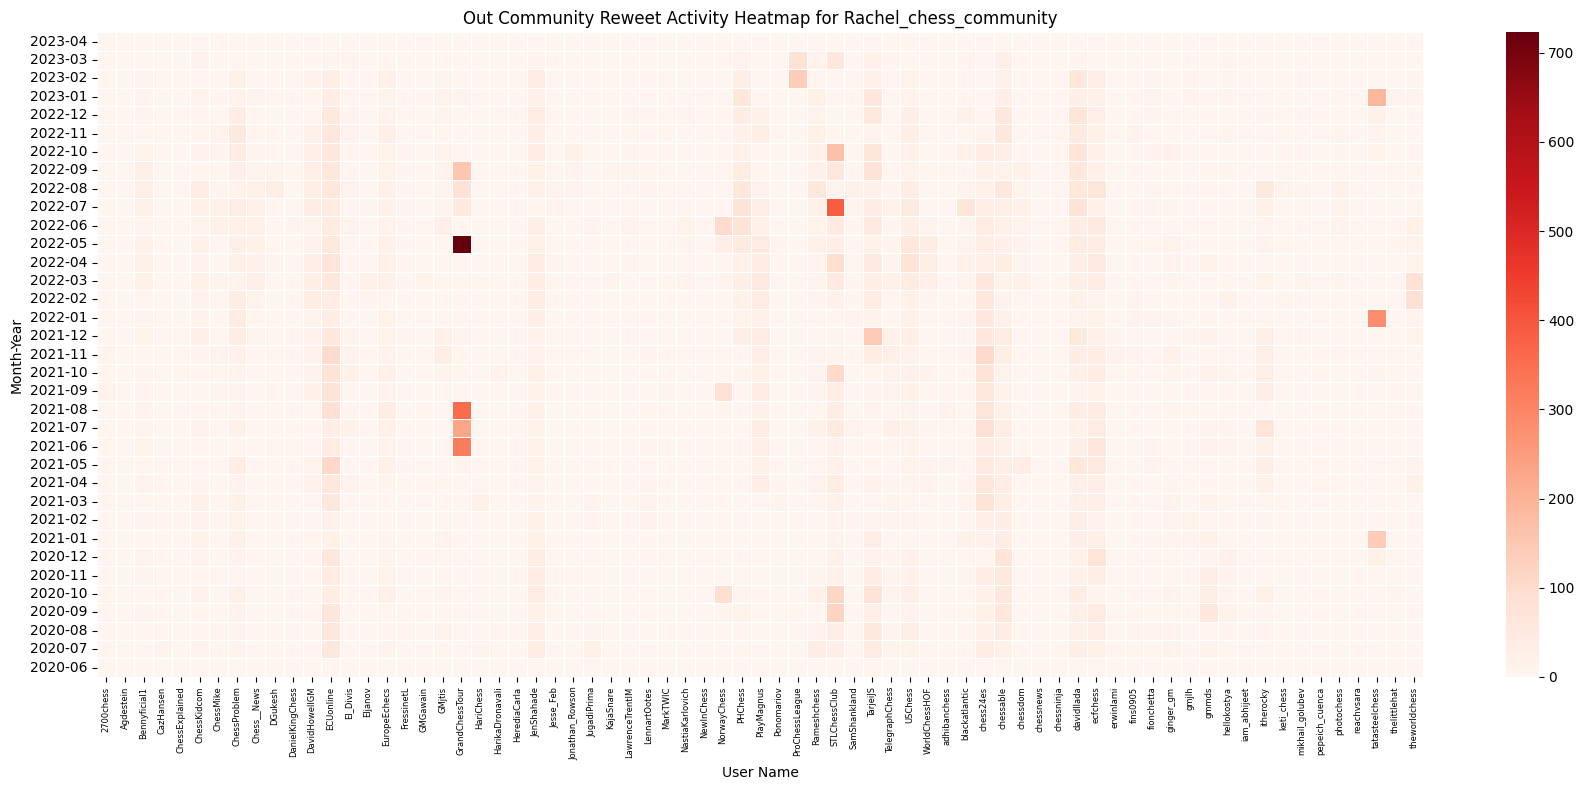

In [34]:
total_retweets_out = defaultdict(list) # to be used later for avg
top_users_by_community_retweet_out = {}
bottom_users_by_community_retweet_out = {}
users_no_out_community_retweet = defaultdict(list)

for community, df in all_retweets_out_community.items():
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['month_year'] = df['created_at'].dt.to_period('M')

    df = pd.merge(df, all_user_info[community], on='user_id', how='left', suffixes=('', '_user_info'))

    # right join to be used later to find users who have not retweeted anything in community
    df_not_tweeted = pd.merge(df, all_user_info[community], on='user_id', how='right', suffixes=('', '_user_info'))
    users_not_tweeted = df_not_tweeted[df_not_tweeted['created_at'].isna()]
    usernames_not_tweeted = users_not_tweeted['username_user_info'].to_list()
    users_no_out_community_retweet[community] = usernames_not_tweeted

    # count the tweet per user for each period
    tweet_count = df.groupby(['username', 'month_year']).size()

    # calculate total tweets in that community
    total_retweets_out[community].append(tweet_count.sum())
    total_retweets_out[community].append(all_user_info[community]['user_id'].nunique())

    # calculate the top users in that community
    tweet_count_per_user = tweet_count.groupby('username').sum()
    top_20_users = tweet_count_per_user.sort_values(ascending=False).head(20)
    top_users_by_community_retweet_out[community] = top_20_users

    # calculate the bottom users in that community
    bottom_20_users = tweet_count_per_user.sort_values(ascending=True).head(20)
    bottom_users_by_community_retweet_out[community] = bottom_20_users

    # convert series to dataframe for heatmap and transpose
    tweet_count_unstacked = tweet_count.unstack(fill_value=0).T
    tweet_count_unstacked.columns = tweet_count_unstacked.columns.astype(str)

    #create the plot
    plt.figure(figsize=(len(tweet_count_unstacked.columns) / 4, 8))
    plt.ticklabel_format(style='plain', axis='x')

    sns.heatmap(tweet_count_unstacked, cmap="Reds", linewidths=.5)
    
    plt.xlabel('User Name')
    plt.ylabel('Month-Year')
    plt.title(f'Out Community Reweet Activity Heatmap for {community.capitalize()}')

    plt.gca().invert_yaxis()
    plt.xticks(rotation=90, fontsize=6)
    plt.tight_layout()
    plt.show()

## Users who got retweeted the most by out community members

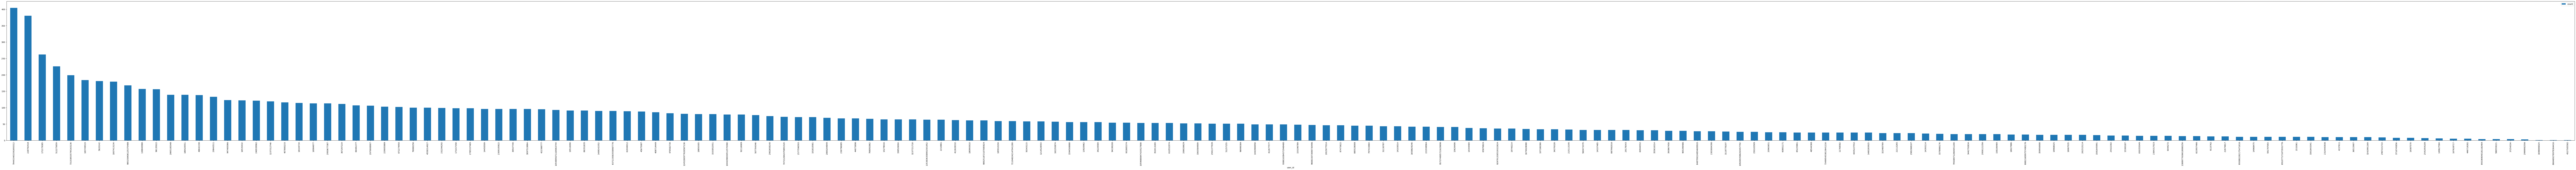

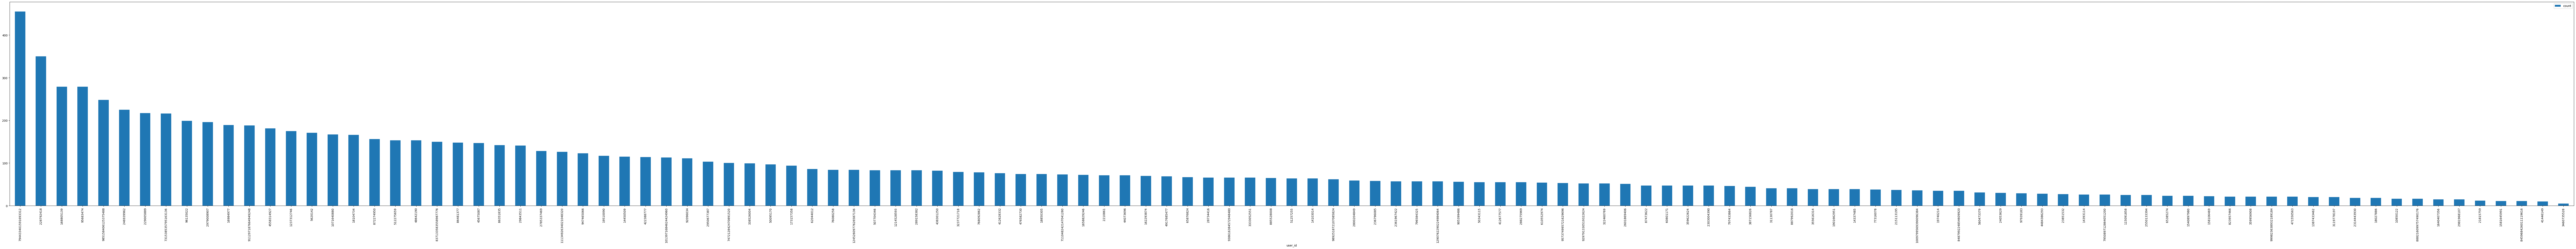

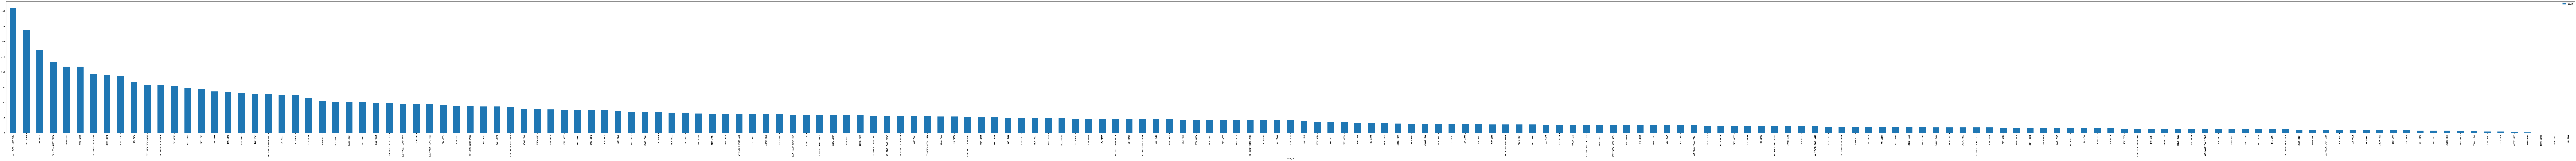

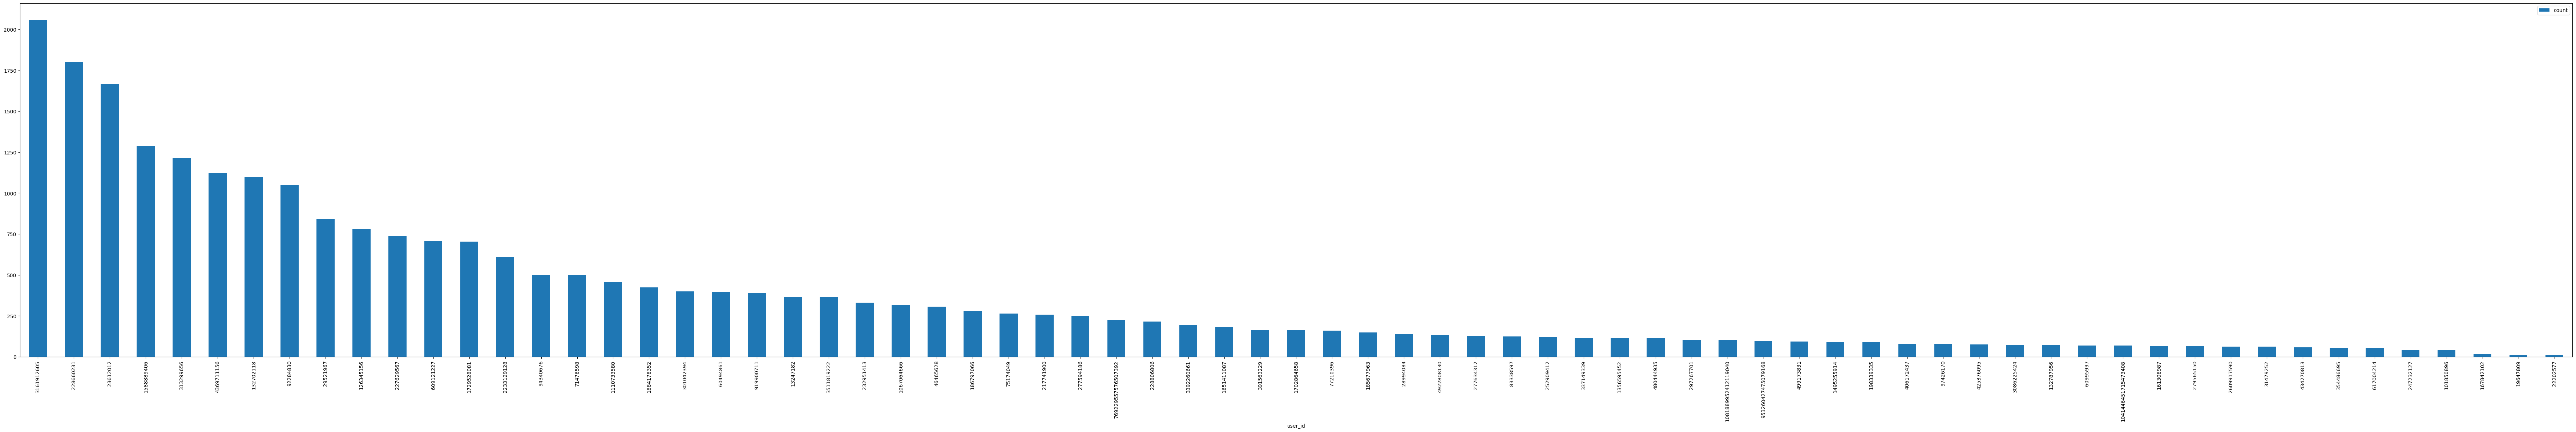

In [37]:
for community, retweet in all_retweets_out_community.items():
    retweet_counts = retweet.groupby('retweet_user_id').size().reset_index(name='count')
    retweet_counts_df = pd.DataFrame({
        "user_id": retweet_counts['retweet_user_id'],
        "count": retweet_counts['count']
    })
    retweet_counts_df = retweet_counts_df.sort_values(by='count', ascending=False)
    plt.figure(figsize=(len(retweet_counts_df), 12))
    retweet_counts_df.plot(kind='bar', x='user_id', y='count', ax=plt.gca())
    plt.tight_layout()
    plt.show()

## Average Retweets in Each Community

In [16]:
out_retweet_average = defaultdict(float)
for community, lst in total_retweets_out.items():
    average = lst[0] / lst[1]
    out_retweet_average[community] = average

average_df = pd.DataFrame.from_dict(out_retweet_average, orient='index', columns=['Average Retweets per User'])
print(average_df)

                               Average Retweets per User
070823_ml_community_4                          55.821429
ml_community_1                                 75.782609
new_all_tweets_ml_community_2                  49.299539
rachel_chess_community                        336.065789


## Top and Bottom Retweeters in Each Community
- Here we are only looking at those who retweeted something

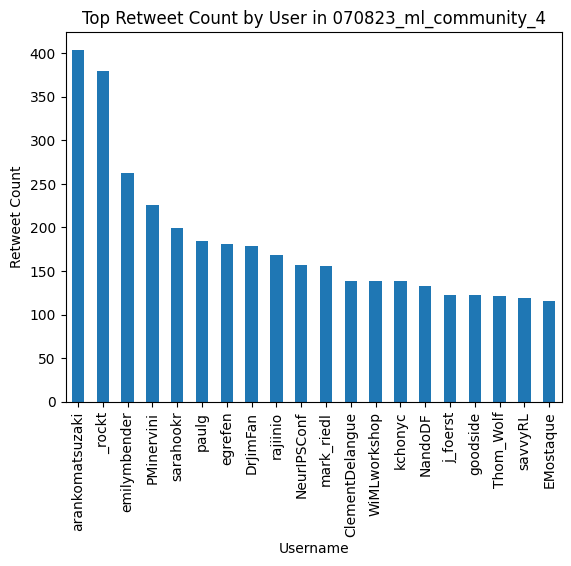

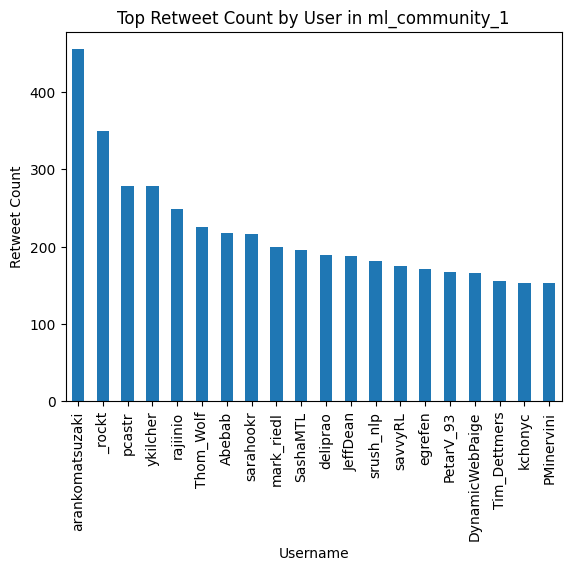

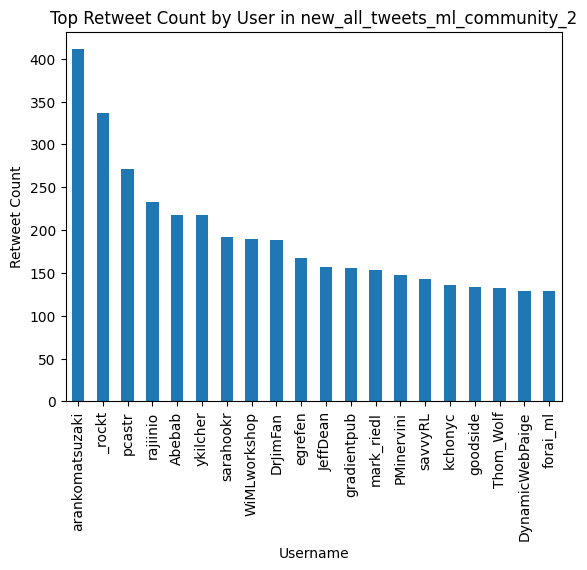

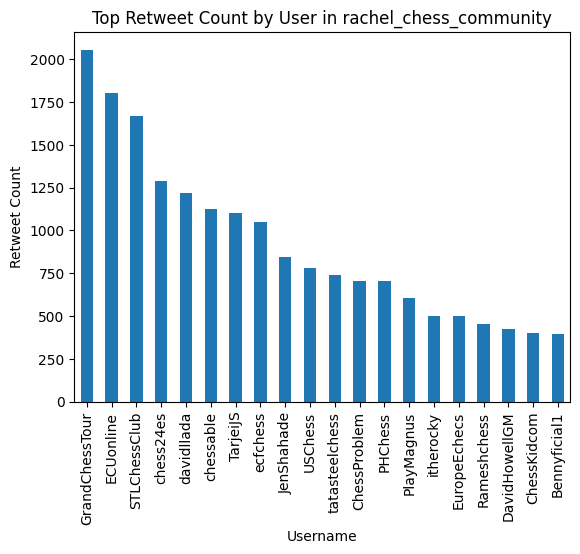

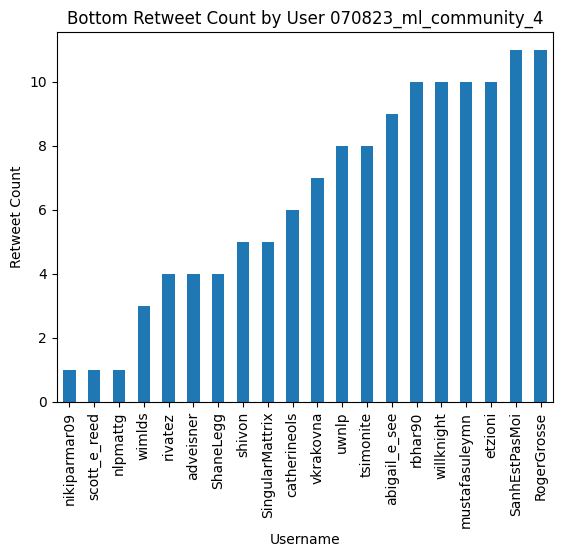

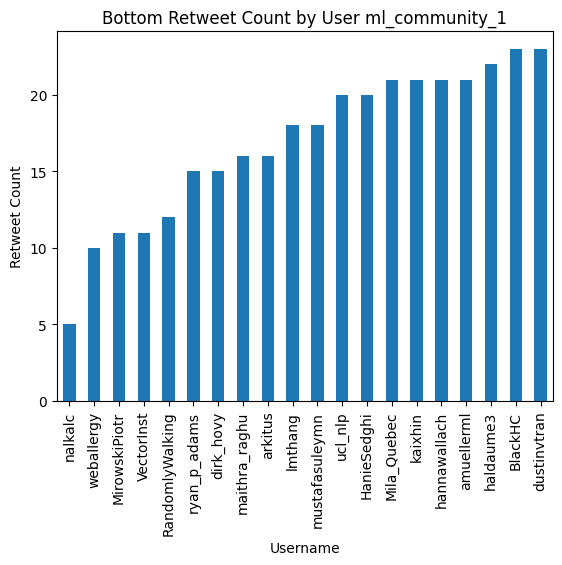

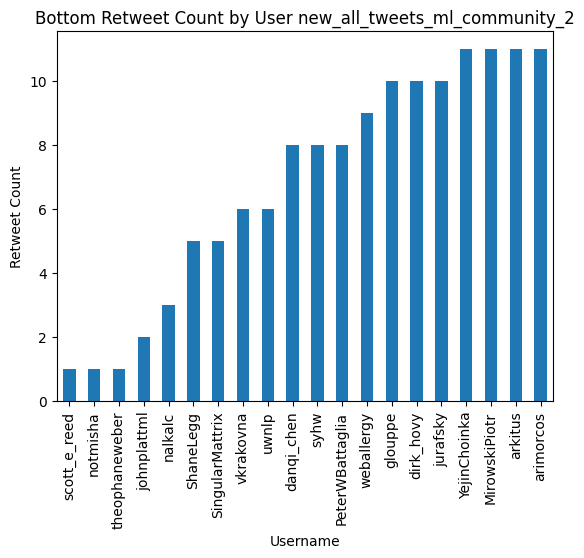

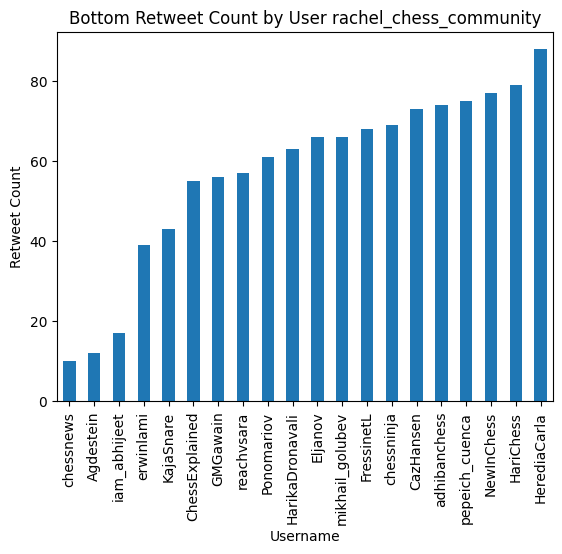

In [17]:
# convert the series to df for better visualization
for community, series in top_users_by_community_retweet_out.items():
    df = series.reset_index()
    df.columns = ['Username', 'Retweet Count']
    df.plot(kind='bar', x='Username', y='Retweet Count', legend=False)
    plt.xlabel('Username')
    plt.ylabel('Retweet Count')
    plt.title(f'Top Retweet Count by User in {community}')
    plt.show()

for community, series in bottom_users_by_community_retweet_out.items():
    df = series.reset_index()
    df.columns = ['Username', 'Retweet Count']
    df.plot(kind='bar', x='Username', y='Retweet Count', legend=False)
    plt.xlabel('Username')
    plt.ylabel('Retweet Count')
    plt.title(f'Bottom Retweet Count by User {community}')
    plt.show()

## Users Who Have Never Retweeted Anything Out Community

In [18]:
for community, series in users_no_out_community_retweet.items():
    print(community)
    print("Total user count: " + str(len(series)))
    print(series)
    print('\n')

070823_ml_community_4
Total user count: 16
['mmitchell_ai', 'LukeZettlemoyer', 'CohereAI', '_jasonwei', 'mervenoyann', 'HochreiterSepp', 'zzznah', 'BlancheMinerva', 'woj_zaremba', 'Diyi_Yang', 'janleike', 'dileeplearning', 'mo_norouzi', 'polynoamial', 'AnimaAnandkumar', 'AdeptAILabs']


ml_community_1
Total user count: 15
['CohereAI', 'yeewhye', 'MLStreetTalk', 'alex_conneau', 'polynoamial', '_jasonwei', 'mmitchell_ai', 'AndrewLampinen', 'mo_norouzi', 'neuro_kim', 'gregd_nlp', 'neu_rips', 'zzznah', 'vdbergrianne', 'CShorten30']


new_all_tweets_ml_community_2
Total user count: 26
['_jasonwei', 'mo_norouzi', 'LukeZettlemoyer', 'yeewhye', 'vdbergrianne', 'ELLISforEurope', 'santoroAI', 'AndrewLampinen', 'polynoamial', 'svlevine', 'EthanJPerez', 'ibab_ml', 'CohereAI', 'ml_perception', 'iatitov', 'HochreiterSepp', 'dileeplearning', 'neu_rips', 'alex_conneau', 'AdeptAILabs', 'woj_zaremba', 'zzznah', 'gregd_nlp', 'neuro_kim', 'janleike', 'BlancheMinerva']


rachel_chess_community
Total user c

# Retweets of In Community by Out Community
- *retweet_of_out_community_by_in_community*: tweets that are posted by in community members but got retweeted by out community members
- *user_id* is the user id of the in community member,  *retweet_user_id* is the id of the out of community member 

In [39]:
all_retweets_by_out_community = {}
for db_name in databases:
    db = client[db_name]

    retweet_collection = db['retweets_of_out_community_by_in_community']

    retweet_df = pd.DataFrame(list(retweet_collection.find()))
    retweet_df['user_id'] = retweet_df['user_id'].astype(int)
    all_retweets_by_out_community[db_name] = retweet_df


# 1. create the plot for total tweets
total_counts = {db_name: df.shape[0] for db_name, df in all_retweets_by_out_community.items()}
db_names = list(total_counts.keys())
counts = list(total_counts.values())

plt.figure()
plt.bar(db_names, counts)
plt.xlabel('Community')
plt.ylabel('Total Number of Retweets')
plt.title('Total Number of In Community Retweets by Out Community')

plt.xticks(rotation=45, ha='right')
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

## In Community Retweets by Out Community Users Distribution
- Here we are looking at which user's tweets got retweeted the most by others out of the community

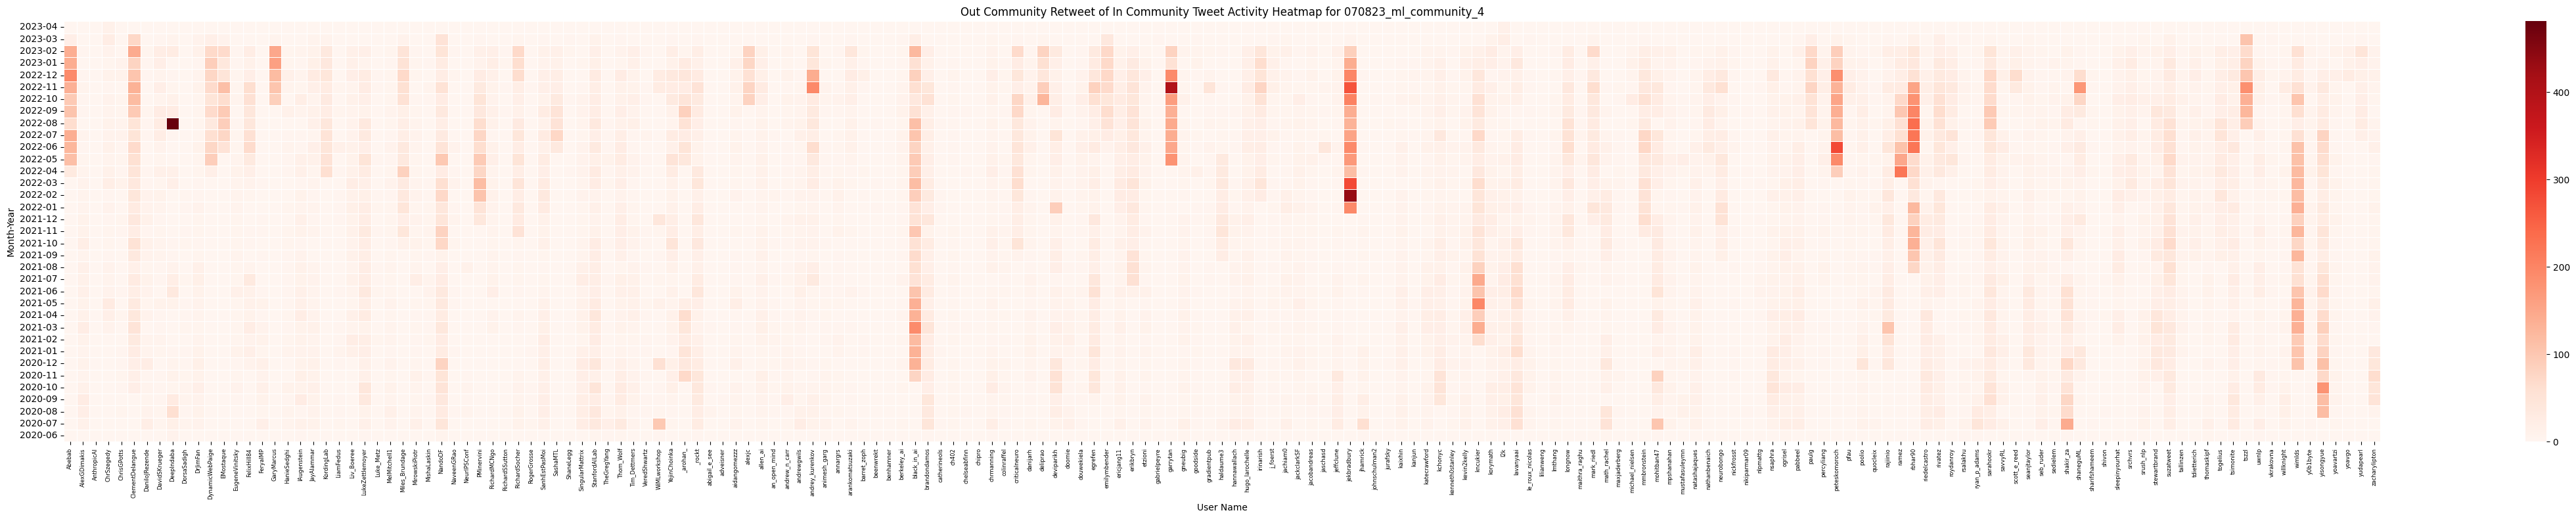

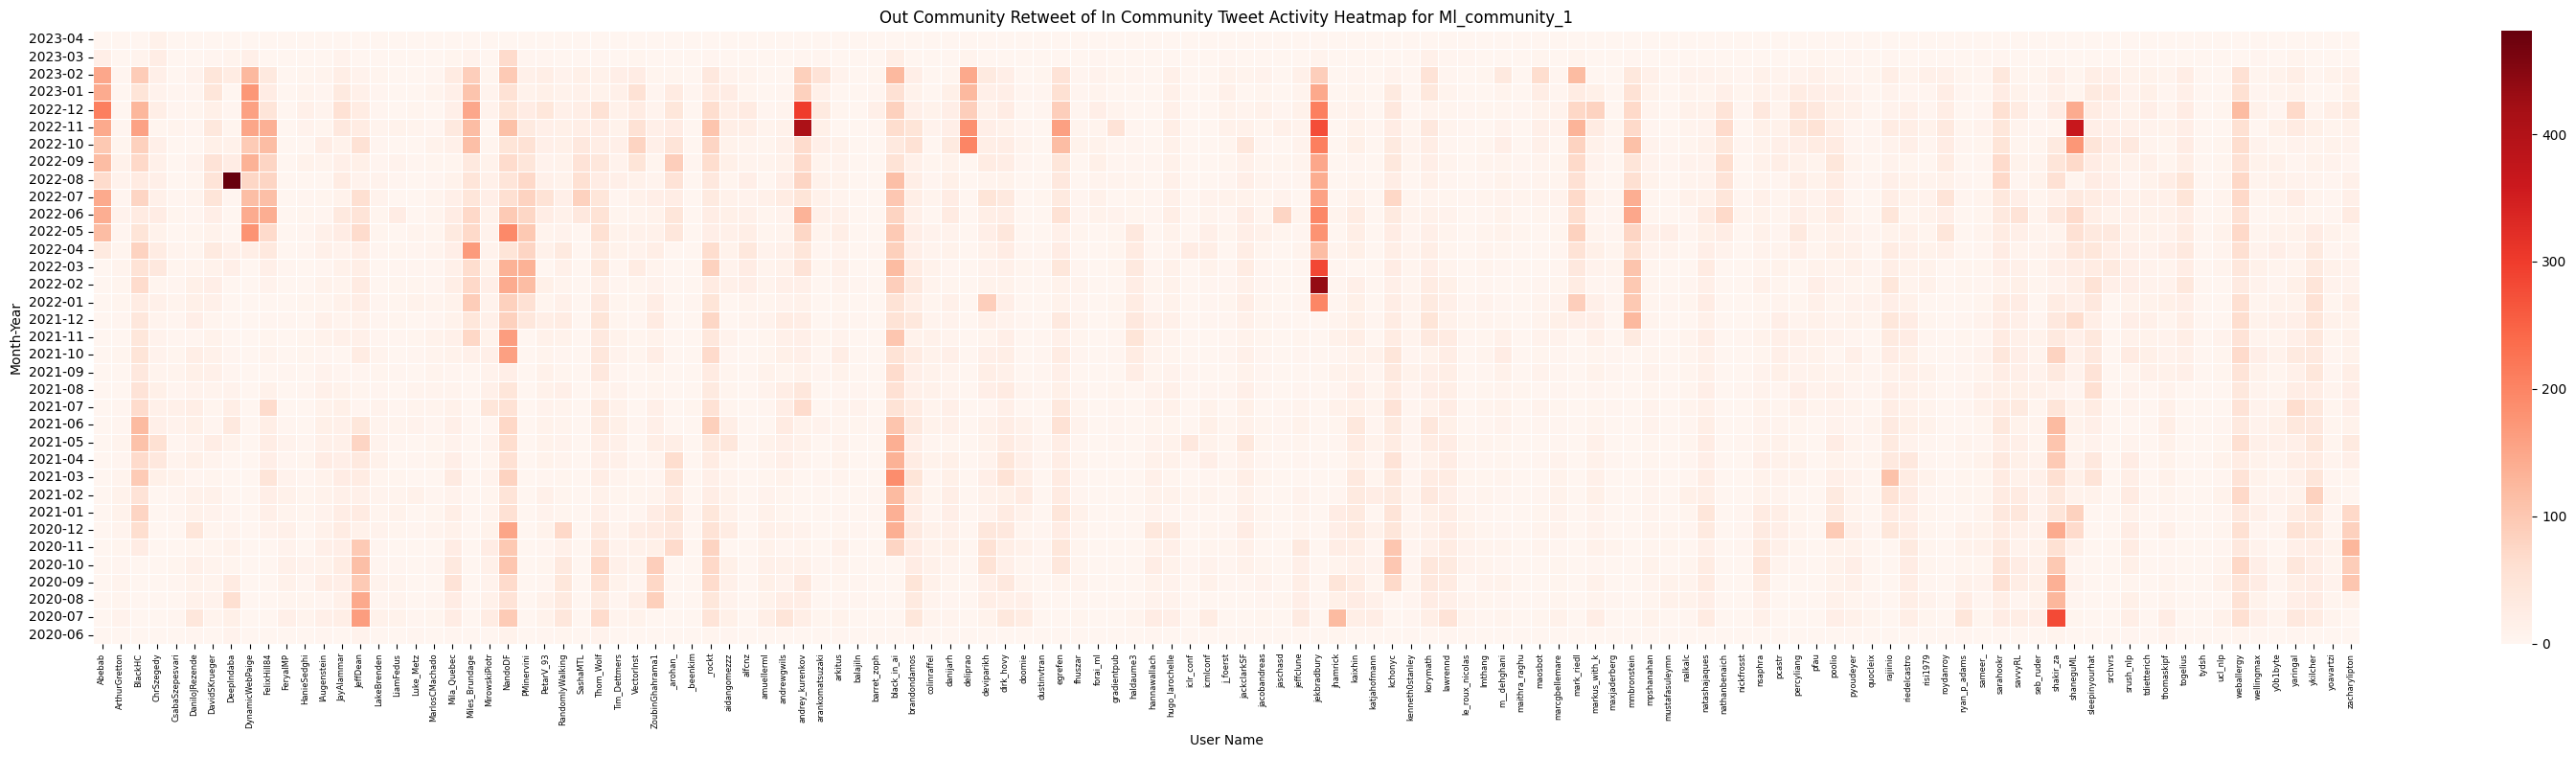

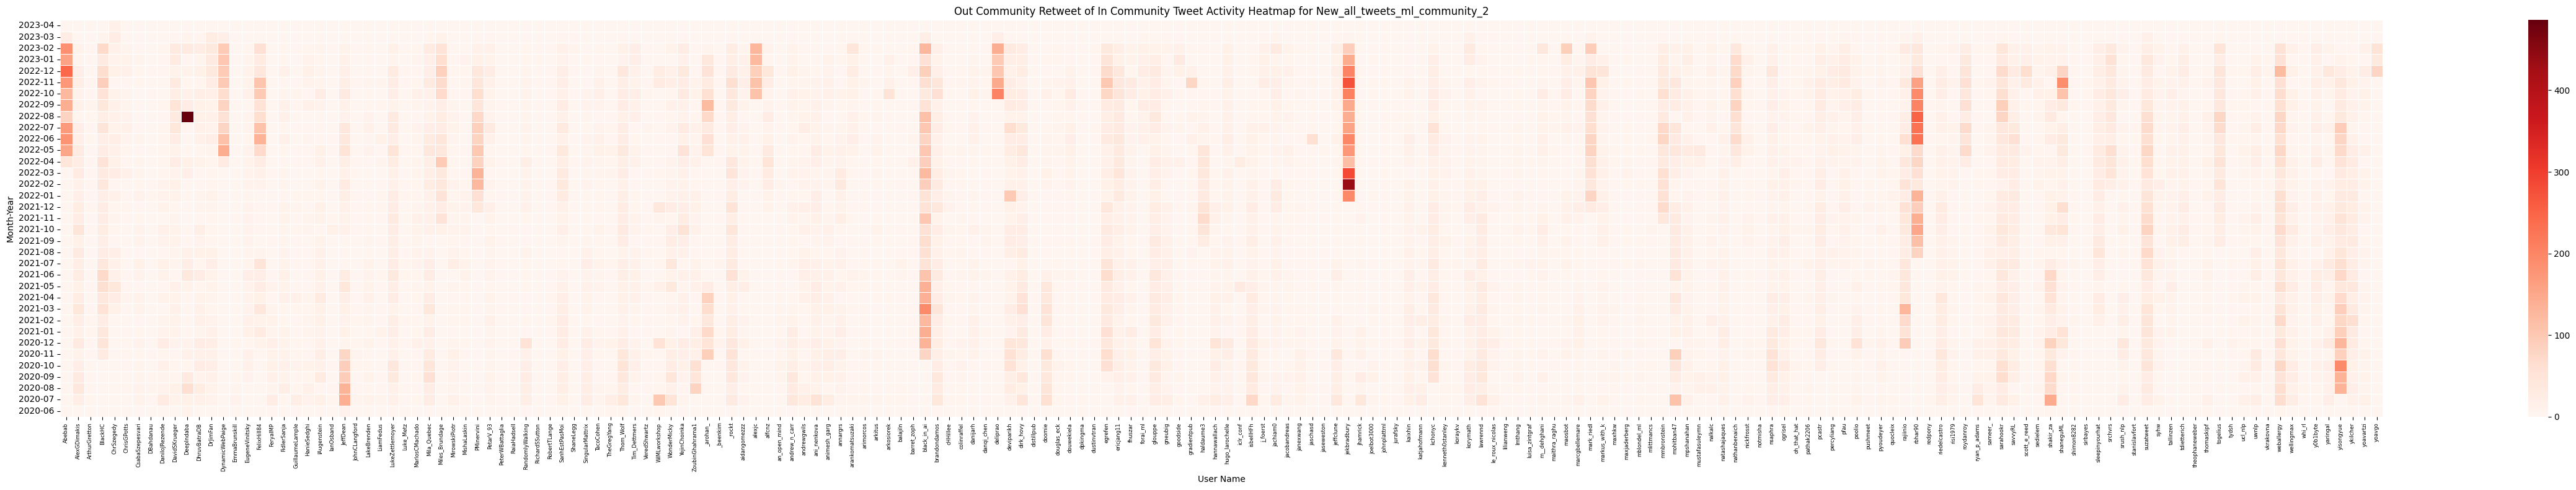

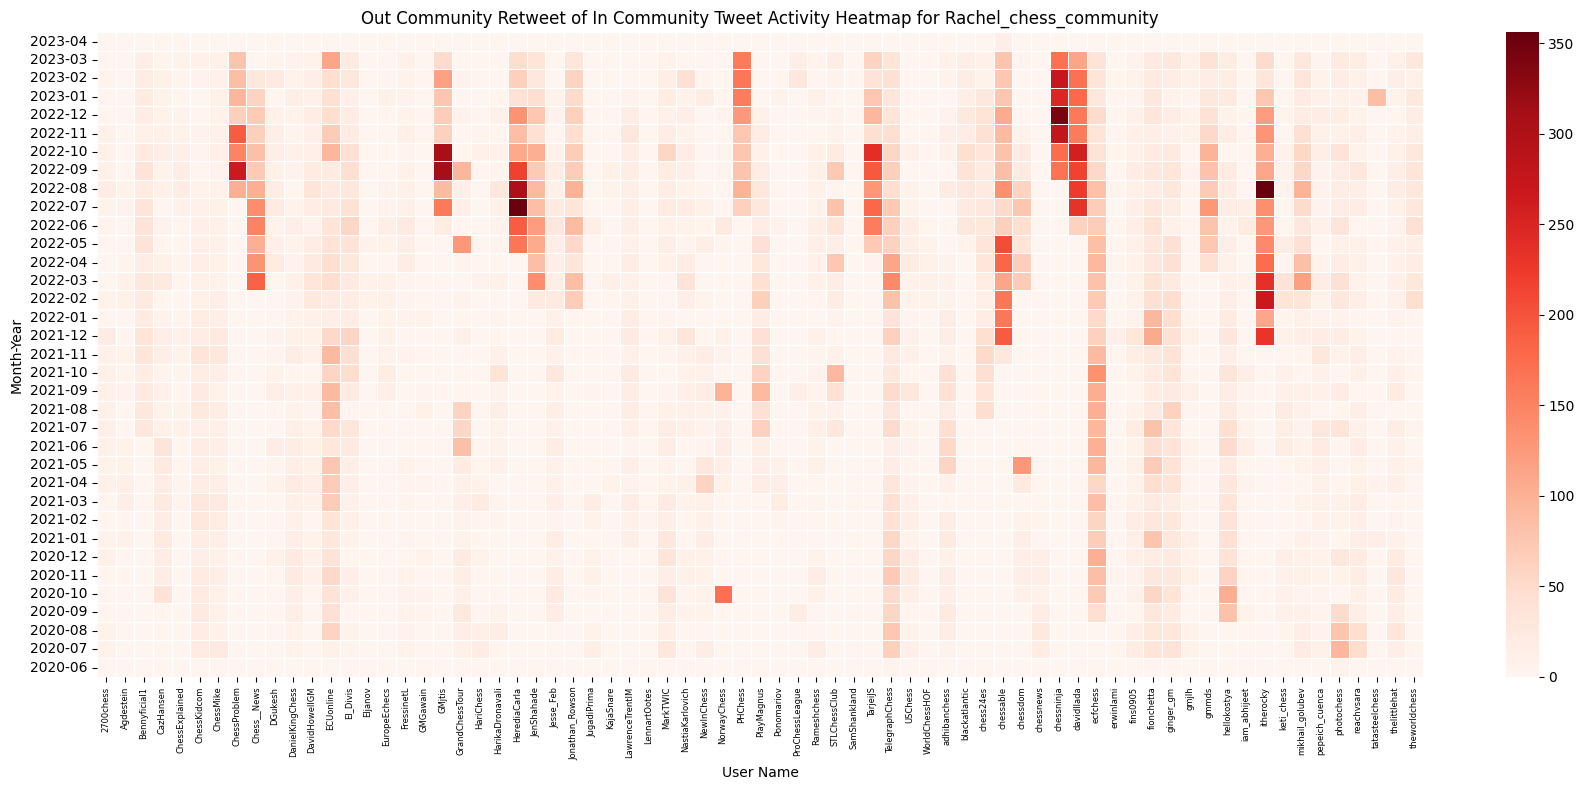

In [20]:
total_retweets_by_out = defaultdict(list) # to be used later for avg
top_users_by_community_retweet_by_out = {}
bottom_users_by_community_retweet_by_out = {}
users_got_no_retweet = defaultdict(list)

for community, df in all_retweets_by_out_community.items():
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['month_year'] = df['created_at'].dt.to_period('M')

    df = pd.merge(df, all_user_info[community], on='user_id', how='left', suffixes=('', '_user_info'))

    # right join to be used later to find users who have did not get retweeted by out of community members
    df_not_tweeted = pd.merge(df, all_user_info[community], on='user_id', how='right', suffixes=('', '_user_info'))
    users_not_tweeted = df_not_tweeted[df_not_tweeted['created_at'].isna()]
    usernames_not_tweeted = users_not_tweeted['username_user_info'].to_list()
    users_got_no_retweet[community] = usernames_not_tweeted

    # count the tweet per user for each period
    tweet_count = df.groupby(['username', 'month_year']).size()

    # calculate total tweets in that community
    total_retweets_by_out[community].append(tweet_count.sum())
    total_retweets_by_out[community].append(all_user_info[community]['user_id'].nunique())

    # calculate the top users in that community
    tweet_count_per_user = tweet_count.groupby('username').sum()
    top_20_users = tweet_count_per_user.sort_values(ascending=False).head(20)
    top_users_by_community_retweet_by_out[community] = top_20_users

    # calculate the bottom users in that community
    bottom_20_users = tweet_count_per_user.sort_values(ascending=True).head(20)
    bottom_users_by_community_retweet_by_out[community] = bottom_20_users

    # convert series to dataframe for heatmap and transpose
    tweet_count_unstacked = tweet_count.unstack(fill_value=0).T
    tweet_count_unstacked.columns = tweet_count_unstacked.columns.astype(str)

    #create the plot
    plt.figure(figsize=(len(tweet_count_unstacked.columns) / 4, 8))
    plt.ticklabel_format(style='plain', axis='x')

    sns.heatmap(tweet_count_unstacked, cmap="Reds", linewidths=.5)
    
    plt.xlabel('User Name')
    plt.ylabel('Month-Year')
    plt.title(f'Out Community Retweet of In Community Tweet Activity Heatmap for {community.capitalize()}')

    plt.gca().invert_yaxis()
    plt.xticks(rotation=90, fontsize=6)
    plt.tight_layout()
    plt.show()

## Average Retweets per User

In [21]:
by_out_retweet_average = defaultdict(float)
for community, lst in total_retweets_by_out.items():
    average = lst[0] / lst[1]
    by_out_retweet_average[community] = average

average_df = pd.DataFrame.from_dict(by_out_retweet_average, orient='index', columns=['Average Retweets per User'])
print(average_df)

                               Average Retweets per User
070823_ml_community_4                         381.867347
ml_community_1                                487.115942
new_all_tweets_ml_community_2                 353.811060
rachel_chess_community                        576.868421


## Top and Bottom Users Who Got the Most and Least Retweets
- Only checking those who has tweeted someting

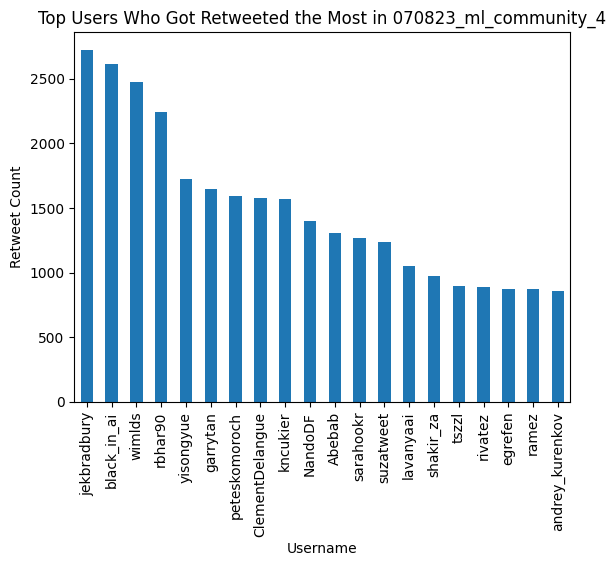

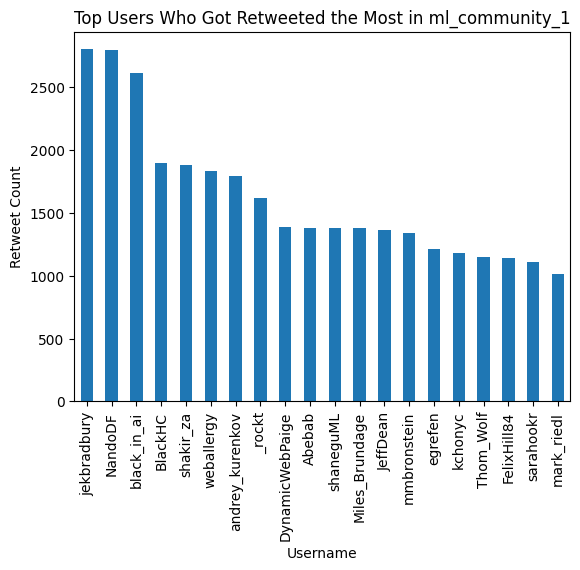

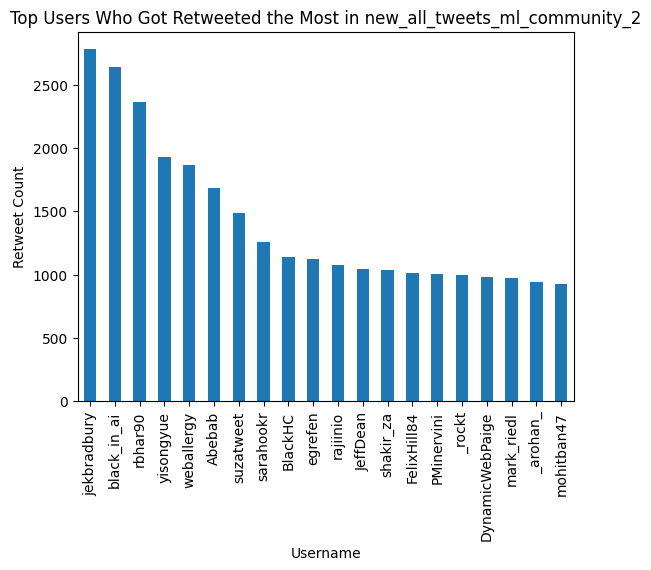

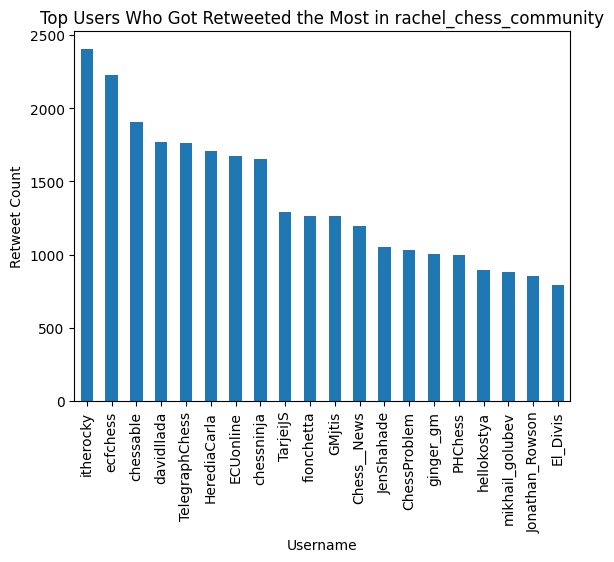

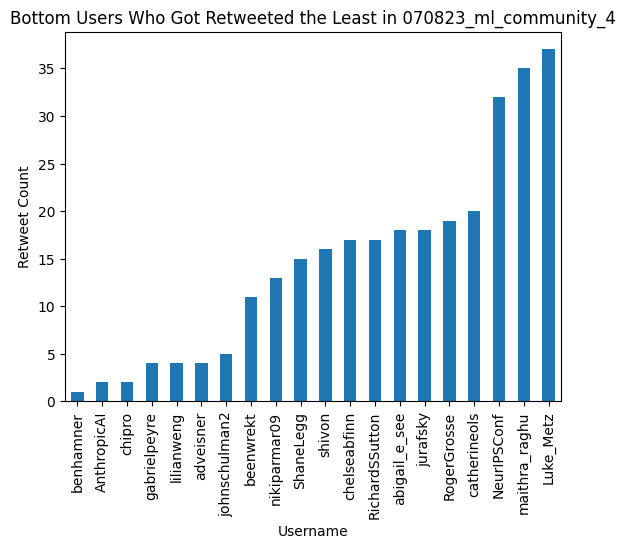

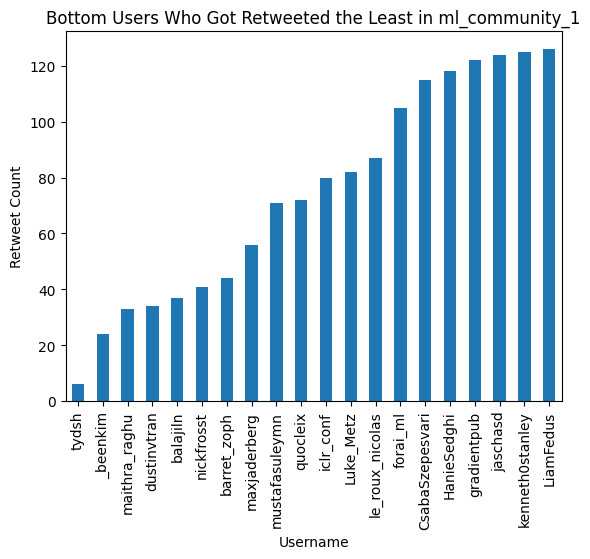

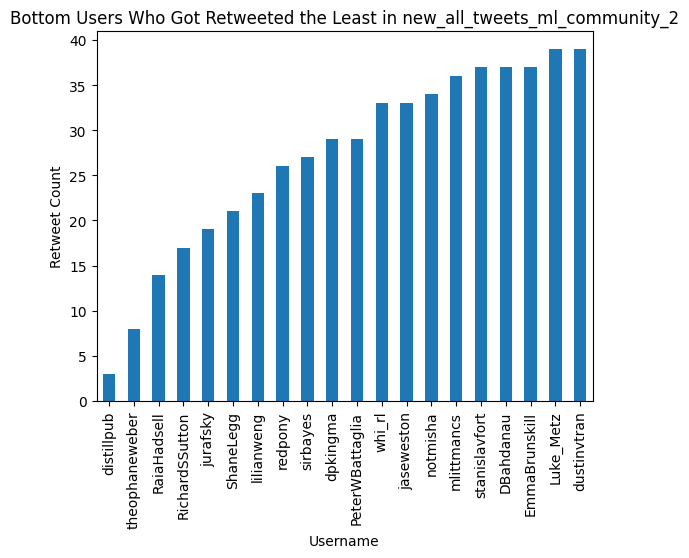

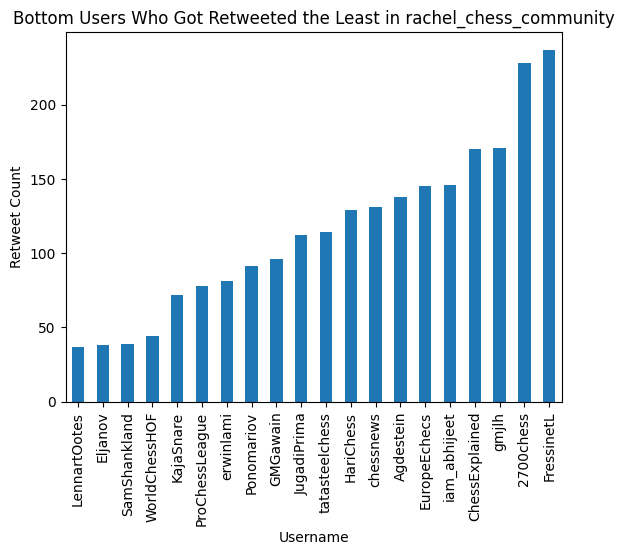

In [22]:
# convert the series to df for better visualization
for community, series in top_users_by_community_retweet_by_out.items():
    df = series.reset_index()
    df.columns = ['Username', 'Retweet Count']
    df.plot(kind='bar', x='Username', y='Retweet Count', legend=False)
    plt.xlabel('Username')
    plt.ylabel('Retweet Count')
    plt.title(f'Top Users Who Got Retweeted the Most in {community}')
    plt.show()

for community, series in bottom_users_by_community_retweet_by_out.items():
    df = series.reset_index()
    df.columns = ['Username', 'Retweet Count']
    df.plot(kind='bar', x='Username', y='Retweet Count', legend=False)
    plt.xlabel('Username')
    plt.ylabel('Retweet Count')
    plt.title(f'Bottom Users Who Got Retweeted the Least in {community}')
    plt.show()

## Users Who Got No Retweets of Out of Community Members

In [23]:
for community, series in users_got_no_retweet.items():
    print(community)
    print("Total user count: " + str(len(series)))
    print(series)
    print('\n')

070823_ml_community_4
Total user count: 15
['mmitchell_ai', 'CohereAI', '_jasonwei', 'mervenoyann', 'HochreiterSepp', 'zzznah', 'BlancheMinerva', 'woj_zaremba', 'Diyi_Yang', 'janleike', 'dileeplearning', 'mo_norouzi', 'polynoamial', 'AnimaAnandkumar', 'AdeptAILabs']


ml_community_1
Total user count: 15
['CohereAI', 'yeewhye', 'MLStreetTalk', 'alex_conneau', 'polynoamial', '_jasonwei', 'mmitchell_ai', 'AndrewLampinen', 'mo_norouzi', 'neuro_kim', 'gregd_nlp', 'neu_rips', 'zzznah', 'vdbergrianne', 'CShorten30']


new_all_tweets_ml_community_2
Total user count: 25
['_jasonwei', 'mo_norouzi', 'yeewhye', 'vdbergrianne', 'ELLISforEurope', 'santoroAI', 'AndrewLampinen', 'polynoamial', 'svlevine', 'EthanJPerez', 'ibab_ml', 'CohereAI', 'ml_perception', 'iatitov', 'HochreiterSepp', 'dileeplearning', 'neu_rips', 'alex_conneau', 'AdeptAILabs', 'woj_zaremba', 'zzznah', 'gregd_nlp', 'neuro_kim', 'janleike', 'BlancheMinerva']


rachel_chess_community
Total user count: 5
['ChampChessTour', 'chesscom_i